In [1]:
from __future__ import print_function
import pandas as pd
import os,sys
#import pybedtools as pbt
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from mapper import expand, parse_mapping_table, apply_mappers


In [2]:
OncoKB_annotated = pd.read_csv("data/hotspots/OncoKB/cancerGeneList.tsv",sep ="\t")
OncoKB_annotated = OncoKB_annotated.loc[OncoKB_annotated['OncoKB Annotated'] == 'Yes']
OncoKB_annotated.to_csv ("data/hotspots/OncoKB/allAnnotatedVariants.tsv", index = False, header=True)

In [3]:
OncoKB_mut = pd.read_csv("data/hotspots/OncoKB/allAnnotatedVariants.tsv",sep ="\t")
OncoKB_gtype = pd.read_csv("data/hotspots/OncoKB/OncoKB_gene_type.txt",sep ="\t")
OncoKB_gtype = OncoKB_gtype[['Hugo Symbol ', u'Oncogene /TSG ']]
OncoKB = {"OG":'Oncogene ',"TSG":'TSG ',"OG_TSG":'Oncogene,TSG '}
for key in OncoKB.keys():
    OncoKB[key] = set(map(str.rstrip, list(set(OncoKB_gtype.loc[OncoKB_gtype['Oncogene /TSG ']== OncoKB[key],'Hugo Symbol '].values))))

OncoKB["OG"].update(OncoKB["OG_TSG"])
OncoKB["TSG"].update(OncoKB["OG_TSG"]) 
print("OncoKB OG:",len(OncoKB["OG"]),"TSG:",len(OncoKB["TSG"]),"OG_TSG:",len(OncoKB["OG_TSG"]))

OncoKB OG: 214 TSG: 246 OG_TSG: 25


### Functions

In [4]:
# gene_id - Entrez Gene ID 
# df - all mutations in sample
#    columns: "aa_pos","function", "Entrez_gene_ID"
# hotspots - table of known hotsport  "Entrez_gene_ID" and "aa_pos"

def distance_to_hotspot(gene_id,df_gene, hotspots):
    '''Returns minimal distance between point mutation in gene and known hotspot'''
    # consider only GoF because LoF affect the whole protein and not a certian point
    df_gene = df_gene.loc[df_gene["function"] == "point_mutation"]
    df_hotspots = hotspots.loc[hotspots["Entrez_gene_ID"] == gene_id, :]
    dist = 100000
    for s,e in set(df_gene["aa_pos"].values):
        for hs, he in set(df_hotspots["aa_pos"].values):
            dist = min(dist, abs(s-hs),abs(s-he), abs(e-hs), abs(e-he))
    return dist

def mutations2score(df,TSG,OG,hotspots, w=0.05,verbose = False):
    # define gene type
    gene_scores = {}
    for gene_id in list(set(df["Entrez_gene_ID"].values)):
        df_gene = df.loc[df["Entrez_gene_ID"] == gene_id, :]
        # functions of mutations
        mut_functions = set(df_gene["function"].values)
        if gene_id in TSG:
            # check for truncating mutations:
            # score is -1 if any
            if "truncating_mutation" in mut_functions:
                gene_scores[gene_id] =-1
            else:
                # in mutation is not truncating, 
                # get the distance to closets hotspot if any 
                dist = distance_to_hotspot(gene_id, df_gene, hotspots)
                # set abs. maximal of 1/(dist+1) and 2w which corresponds LoF in unannotatedd gene
                gene_scores[gene_id] = -max(1.0/(dist+1),2*w)
        elif gene_id in OG:
            if "point_mutation" in mut_functions:
                dist = distance_to_hotspot(gene_id, df_gene, hotspots)
                if "truncating_mutation" in mut_functions:
                    if verbose:
                        print("GoF at dist",dist,"from hotspot in Oncogene with GoF",file = sys.stderr)
                        print(df_gene,file = sys.stderr)
                    if 1.0/(dist+1) > 2*w:
                        # if there is a mutation close to hotspot
                        # despite LoF it is likely a driver and the second copy of this gene is broken
                        # this happens in sampl 905968  in PIK3CA gene (5290)
                        gene_scores[gene_id] = 1.0/(dist+1)
                    else:
                        # otherwise we set -1 to differentiate it from neutral mutations
                        # because oncogene might turn on after domain truncation
                        gene_scores[gene_id] = -1
                else:
                    # non-hotspot mutation in non-LoF oncogene - small positive value
                    gene_scores[gene_id] = max(1.0/(dist+1),w)
            else:
                # only LoF mutations, oncogene is likely not functional or
                # it is turned-on after truncting mutations
                # therefore we set -1 to differentiate it from neutral mutations
                gene_scores[gene_id] = -1
            
            
        else: # if unknown_significance
            if "truncating_mutation" in mut_functions:
                gene_scores[gene_id] = -2.0*w
            else:
                gene_scores[gene_id] = -w
    
    return pd.Series(gene_scores)

In [5]:
bailye = {"OG":[],"TSG":[],"OG_TSG":[]}
bailye_drivers = pd.read_excel("data/hotspots/Bailey_2018.mmc1.xlsx", sheet_name="Table S1", 
                               skiprows = 3)
bailye_drivers = bailye_drivers[["Gene","Tumor suppressor or oncogene prediction (by 20/20+)"]]
#print(bailye_drivers.shape[0])
bailye_drivers.drop_duplicates(inplace=True)
bailye_drivers.columns = ["gene", "role"]
#print(bailye_drivers.shape[0])
bailye_drivers.fillna("NA", inplace = True)
bailye_drivers["role"] = bailye_drivers["role"].apply(lambda x: x.replace("possible ",""))
bailye_drivers.drop_duplicates(inplace=True)
#print(bailye_drivers.shape[0])
bailye_drivers.loc[bailye_drivers.duplicated("gene", keep=False),:]
#print(len(set(bailye_drivers["gene"].values)))
bailye["OG"] = bailye_drivers.loc[bailye_drivers["role"] == "oncogene",:]
bailye["OG"] = set(bailye["OG"]["gene"].values)
bailye["TSG"] = bailye_drivers.loc[bailye_drivers["role"] == "tsg",:]
bailye["TSG"] = set(bailye["TSG"]["gene"].values)
bailye["OG_TSG"] = bailye["OG"].intersection(bailye["TSG"])
print("Bailey_2018 OG:",len(bailye["OG"]),"TSG:",len(bailye["TSG"]),"both:", len(bailye["OG_TSG"]))
#print(len(OncoKB["OG"]),len(OncoKB["TSG"]),len(OncoKB["OG_TSG"]) )

Bailey_2018 OG: 115 TSG: 162 both: 18


### Hotspots

In [6]:
hotspots2D_subst = pd.read_excel("data/hotspots/hotspots_v2.xls","SNV-hotspots")
hotspots2D_indels = pd.read_excel("data/hotspots/hotspots_v2.xls","INDEL-hotspots")
print("1D mutations",hotspots2D_subst.shape[0],hotspots2D_indels.shape[0] )
hotspots2D_subst = hotspots2D_subst.loc[~hotspots2D_subst["Amino_Acid_Position"].str.contains("splice")]
hotspots2D_subst = hotspots2D_subst[["Hugo_Symbol","Amino_Acid_Position"]]
hotspots2D_subst.drop_duplicates(inplace=True)
hotspots2D_indels = hotspots2D_indels[["Hugo_Symbol","Amino_Acid_Position"]]
hotspots2D_indels.drop_duplicates(inplace=True)
print("1D hotspots",hotspots2D_subst.shape[0],hotspots2D_indels.shape[0] )
cBioPortal_muts = pd.concat([hotspots2D_subst,hotspots2D_indels],axis =0)
cBioPortal_muts_ = cBioPortal_muts.loc[cBioPortal_muts["Amino_Acid_Position"].str.contains("-"),:]
cBioPortal_muts = cBioPortal_muts.loc[~cBioPortal_muts["Amino_Acid_Position"].str.contains("-"),:]
cBioPortal_muts["Amino_Acid_Position"] = cBioPortal_muts["Amino_Acid_Position"].apply(int)
#cBioPortal_muts["start"] = cBioPortal_muts["Amino_Acid_Position"]
#cBioPortal_muts["end"] = cBioPortal_muts["Amino_Acid_Position"]
cBioPortal_muts["aa_pos"] = cBioPortal_muts["Amino_Acid_Position"].apply(lambda x : (x,x))

#cBioPortal_muts_ ["start"] = cBioPortal_muts_["Amino_Acid_Position"].apply(lambda x: int(x.split("-")[0]))
#cBioPortal_muts_["end"] = cBioPortal_muts_["Amino_Acid_Position"].apply(lambda x: int(x.split("-")[1]))
cBioPortal_muts_["aa_pos"] = cBioPortal_muts_["Amino_Acid_Position"].apply(lambda x : tuple(map(int,x.split("-"))))

cBioPortal_muts = pd.concat([cBioPortal_muts_,cBioPortal_muts],axis = 0)
cBioPortal_muts["source"] = "1D"


### 3D

cBioPortal_3D = pd.read_excel("data/hotspots/3d_hotspots.xls","Table S5")
cBioPortal_3D = cBioPortal_3D[["Gene","Amino_Acid_Position"]]
print("3D mutations",cBioPortal_3D.shape[0])
cBioPortal_3D.drop_duplicates(inplace=True)
print("3D hotspots ",cBioPortal_3D.shape[0])
cBioPortal_3D["Amino_Acid_Position"] = cBioPortal_3D["Amino_Acid_Position"].apply(int)
#cBioPortal_3D["start"] = cBioPortal_3D["Amino_Acid_Position"]
#cBioPortal_3D["end"] = cBioPortal_3D["Amino_Acid_Position"]
cBioPortal_3D["aa_pos"] = cBioPortal_3D["Amino_Acid_Position"].apply(lambda x : (x,x))
cBioPortal_3D.rename({"Gene":'Hugo_Symbol'}, axis="columns",inplace=True)
cBioPortal_3D["source"] = "3D"
cBioPortal_muts = cBioPortal_muts[["Hugo_Symbol","aa_pos"]]
cBioPortal_3D = cBioPortal_3D[["Hugo_Symbol","aa_pos"]]
cBioPortal_muts = pd.concat([cBioPortal_3D, cBioPortal_muts],axis=0)
cBioPortal_muts.sort_values(["Hugo_Symbol"],ascending = True,inplace=True)

cBioPortal_genes = set(cBioPortal_muts["Hugo_Symbol"].values)
print("genes with hotspot",len(cBioPortal_genes))
cBioPortal_muts = cBioPortal_muts[["Hugo_Symbol","aa_pos"]]
cBioPortal_muts.drop_duplicates(inplace=True)
print("unique hotspots",cBioPortal_muts.shape[0])
#cBioPortal_muts

1D mutations 3004 495
1D hotspots 1024 55
3D mutations 9512
3D hotspots  3395
genes with hotspot 688
unique hotspots 4258


In [7]:

print("genes with and without mutations")
for kind in ["OG","TSG","OG_TSG"]:
    oncokb = OncoKB[kind].intersection(cBioPortal_genes) 
    b = bailye[kind].intersection(cBioPortal_genes)
    print(kind,"oncokb", len(oncokb),"/",len(OncoKB[kind]),
         "Bailye_2018", len(b),"/",len(bailye[kind]))

genes with and without mutations
OG oncokb 110 / 214 Bailye_2018 81 / 115
TSG oncokb 123 / 246 Bailye_2018 81 / 162
OG_TSG oncokb 15 / 25 Bailye_2018 14 / 18


In [8]:
for kind in ["OG","TSG","OG_TSG"]:
    oncokb = OncoKB[kind]#.intersection(cBioPortal_genes) 
    b = bailye[kind]#.intersection(cBioPortal_genes)
    print(kind,"oncokb", len(oncokb),
         "Bailye_2018", len(b),"union",len(b.union(oncokb)),
         "mutated:",
         len(b.union(oncokb).intersection(cBioPortal_genes)))

OG oncokb 214 Bailye_2018 115 union 277 mutated: 144
TSG oncokb 246 Bailye_2018 162 union 316 mutated: 136
OG_TSG oncokb 25 Bailye_2018 18 union 41 mutated: 28


In [9]:

# TSG - not necessarity with a hotspot, take union of OncoKB and  Bailye_2018
TSG = OncoKB["TSG"].union(bailye["TSG"])
# OG - must have a hotspot 
OG = OncoKB["OG"].union(bailye["OG"]).intersection(cBioPortal_genes)
print("TSG:",len(TSG),"with hotspots:",len(TSG.intersection(cBioPortal_genes)),
      "\nOG with hotspots:",len(OG))
# list of hotspots: 
hotspots = cBioPortal_muts.loc[cBioPortal_muts["Hugo_Symbol"].isin(OG|TSG),:]
print("Hotspots (all from cBioPortal):", cBioPortal_muts.shape[0],
      "\n\ton OG:", hotspots.loc[hotspots["Hugo_Symbol"].isin(OG)].shape[0],
      "\n\ton TSG:", hotspots.loc[hotspots["Hugo_Symbol"].isin(TSG)].shape[0])
hotspots.head(5)

TSG: 316 with hotspots: 136 
OG with hotspots: 144
Hotspots (all from cBioPortal): 4258 
	on OG: 1116 
	on TSG: 1012


,Hugo_Symbol,aa_pos
1456,ACVR1,"(206, 206)"
1307,ACVR1,"(258, 258)"
1128,ACVR1,"(328, 328)"
2542,ACVR1B,"(398, 398)"
2056,ACVR1B,"(401, 401)"


### map gene name to Entrez gene ID

In [10]:
NCBI = pd.read_csv("data/Homo_sapiens.gene_info",sep = "\t")
NCBI = NCBI[["#tax_id","GeneID","Symbol","Synonyms","type_of_gene"]]
NCBI = NCBI.loc[NCBI["#tax_id"] == 9606]
NCBI = NCBI.loc[NCBI["type_of_gene"] != "unknown"]
ncbi_symbols = parse_mapping_table(NCBI, "Symbol","GeneID")

Ok: no empty rows detected
Ok: no duplicated pairs detected
Ok: All Symbol rows are not empty.
Ok: All Symbol are mapped to GeneID
9 Symbol mapped to multiple GeneID
Ok: All GeneID are unique
60207 Symbol can be mapped directly to GeneID


In [11]:
ncbi_synonyms = expand(NCBI[["Synonyms","GeneID"]],column="Synonyms",sep="|") 
ncbi_synonyms = parse_mapping_table(ncbi_synonyms, "Synonyms","GeneID")

Ok: no empty rows detected
Ok: no duplicated pairs detected
Ok: All Synonyms rows are not empty.
Ok: All Synonyms are mapped to GeneID
3261 Synonyms mapped to multiple GeneID
50720 different Synonyms mapped to the same GeneID
10915 Synonyms can be mapped directly to GeneID


In [12]:
tsg_og_gene_names = pd.DataFrame.from_dict({"genes":dict(zip(list(OG | TSG),list(OG | TSG)))})
tsg_og_gene_names, query2target, not_mapped = apply_mappers(tsg_og_gene_names, ncbi_symbols, ncbi_synonyms, verbose = True,handle_duplicates = "keep")
OG_entrez = set(map(lambda x : query2target[x],OG))
TSG_entrez = set(map(lambda x : query2target[x],TSG))
hotspots["Entrez_gene_ID"] = hotspots["Hugo_Symbol"].apply(lambda x : query2target[x])
hotspots.head()

Mapped: 421 
	directly via main_mapper 410 
	via alternative mapper 1 
	via one of multiple synonyms in alternative mapper 10 
	LOC 0 
Unmapped: 0 
	recognized symbols without Entrez ID 0 
	multiple query_ids map to the same target_id 0 
	query_ids map to multiple target_ids in the main mapper 0 
	query_ids map to multiple target_ids in the alternative mapper 0 
	LOC not found in Entrez 0 
	Not found at all: 0


IDs mapped to multiple target IDs are kept:
 []
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Hugo_Symbol,aa_pos,Entrez_gene_ID
1456,ACVR1,"(206, 206)",90
1307,ACVR1,"(258, 258)",90
1128,ACVR1,"(328, 328)",90
2542,ACVR1B,"(398, 398)",91
2056,ACVR1B,"(401, 401)",91


### GDSC Mutations

In [13]:
gdsc = pd.read_excel("data/GDSC/WES_variants.xlsx","WES_variants")
gdsc  = gdsc [["COSMIC_ID","Gene","AA","Classification"]]
gdsc.head(3)

,COSMIC_ID,Gene,AA,Classification
0,907272,A1BG,p.Y281C,missense
1,998184,A1BG,p.A197T,missense
2,907272,A1BG,p.A191T,missense


In [14]:
gdsc.groupby("Classification").size().sort_values(ascending = False)

Classification
missense       413252
frameshift      31933
nonsense        23359
ess_splice      13106
inframe          3185
Missense          884
stop_lost         486
gene_fusion        38
dtype: int64

mean 485.7 median 288.0


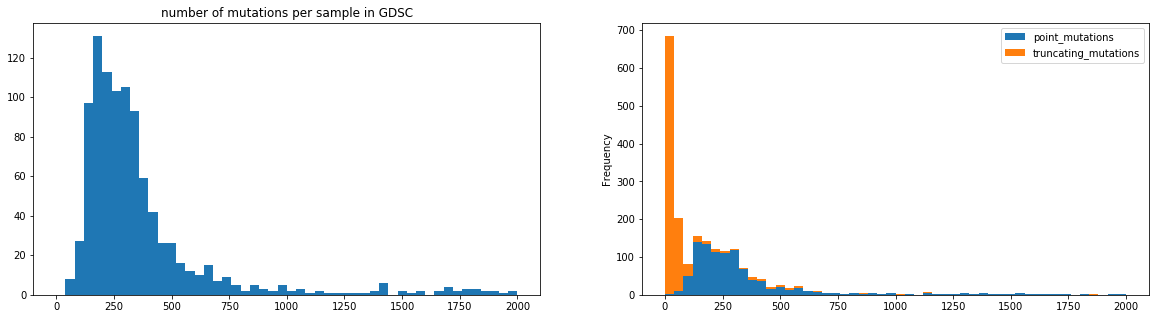

In [15]:
# define functional effect of a mutation 
gdsc_truncating = ['frameshift','nonsense','stop_lost','ess_splice']
gdsc_point = ['missense','Missense','inframe']
gdsc.loc[gdsc["Classification"].isin(gdsc_truncating),"function"] = "truncating_mutation"
gdsc.loc[gdsc["Classification"].isin(gdsc_point),"function"] = "point_mutation"
gdsc = gdsc.loc[gdsc["Classification"].isin(gdsc_truncating+gdsc_point),:]

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
n_mutations_gdsc = gdsc.groupby("COSMIC_ID").size().sort_values(ascending = False)
tmp = plt.hist(n_mutations_gdsc, bins=50,range = (0,2000))
tmp = plt.title("number of mutations per sample in GDSC")
ax = plt.subplot(1,2,2)
n_LoF = gdsc.loc[gdsc["Classification"].isin(gdsc_truncating ),:].groupby("COSMIC_ID").size().sort_values(ascending = False)
n_GoF = gdsc.loc[gdsc["Classification"].isin(gdsc_point),:].groupby("COSMIC_ID").size().sort_values(ascending = False)
df = pd.DataFrame.from_dict({"point_mutations":n_GoF,"truncating_mutations":n_LoF})
#tmp = plt.hist(n_LoF, bins=50)
#tmp = plt.title("LoF mutations per sample in GDSC")
df.plot.hist(stacked = True, bins = 50,ax =ax,range = (0,2000))
print("mean",round(np.mean(n_mutations_gdsc),1), "median",np.median(n_mutations_gdsc))

In [16]:

def binarize(x):
    if x==0:
        return x
    else:
        return 1

def get_aa_pos_GDSC(x):
    l = re.findall(r'\d+', x)
    if len(l) == 0:
        #print(x, "positions not found.",file = sys.stderr)
        return ("NA","NA")
    elif len(l) == 1:
        return (int(l[0]), int(l[0]))
    else:
        return (int(l[0]), int(l[1]))

In [17]:
gdsc["aa_pos"] = gdsc["AA"].apply(lambda x : get_aa_pos_GDSC(x))
#gdsc["start"] = gdsc["aa_pos"].apply(lambda x : x.split(",")[0])
#gdsc["end"] = gdsc["aa_pos"].apply(lambda x : x.split(",")[1])
gdsc.head(5)

,COSMIC_ID,Gene,AA,Classification,function,aa_pos
0,907272,A1BG,p.Y281C,missense,point_mutation,"(281, 281)"
1,998184,A1BG,p.A197T,missense,point_mutation,"(197, 197)"
2,907272,A1BG,p.A191T,missense,point_mutation,"(191, 191)"
3,907289,A1BG,p.D486N,missense,point_mutation,"(486, 486)"
4,905989,A1BG,p.T257N,missense,point_mutation,"(257, 257)"


In [18]:

ensg_genes = []
symbols = []
for gene in set(gdsc["Gene"].values):
    if gene.startswith("ENSG"):
        ensg_genes.append(gene)
        
    else:
        symbols.append(gene)
print("ENSEMBL gene IDs found:",len(ensg_genes))
ensg_genes = gdsc.loc[gdsc["Gene"].isin(ensg_genes), :]
gdsc_hugo =  gdsc.loc[gdsc["Gene"].isin(symbols), :]
print("Gene symbols:",len(set(gdsc_hugo["Gene"].values)))

ENSEMBL gene IDs found: 101
Gene symbols: 18989


In [19]:
# mapping to Entrez
df = gdsc_hugo[["Gene"]].copy()
df.set_index("Gene",drop= False ,inplace=True)
df.drop_duplicates(inplace = True)
df, query2target,not_mapped  = apply_mappers(df, ncbi_symbols, ncbi_synonyms, verbose = True,handle_duplicates = "keep")

Mapped: 18488 
	directly via main_mapper 16719 
	via alternative mapper 490 
	via one of multiple synonyms in alternative mapper 1254 
	LOC 25 
Unmapped: 501 
	recognized symbols without Entrez ID 0 
	multiple query_ids map to the same target_id 0 
	query_ids map to multiple target_ids in the main mapper 0 
	query_ids map to multiple target_ids in the alternative mapper 67 
	LOC not found in Entrez 11 
	Not found at all: 423


IDs mapped to multiple target IDs are kept:
 [143872, 284697, 341019, 27177, 387119, 84530, 26165, 11321, 122945, 150082, 728642, 2122, 442444, 79949, 157777, 6241, 340578, 100289124, 8805, 127602, 387707, 728194, 345222, 84108, 91283, 84631, 144535, 245913, 388761, 4253, 163486, 54438, 283310, 84148, 57018, 284352, 5315, 283849, 339669, 23254, 23272, 119016, 340204, 64753, 64760, 25849, 286464, 129285, 4360, 10507, 4883, 10529, 5414, 23334, 114984, 440107, 256815, 23345, 57662, 165186, 54617, 84316, 200030, 10592, 57705, 246126, 92017, 126321, 10613, 374, 445815, 79741, 51586, 168850, 647060, 284565, 63895, 93081, 201625, 29086, 1954, 9127, 55719, 29099, 941, 155066, 140733, 114112, 85452, 139728, 84458, 23028, 54777, 79868]


In [20]:
gdsc_hugo = gdsc_hugo.loc[~gdsc_hugo["Gene"].isin(not_mapped),:].copy()
gdsc_hugo["Entrez_gene_ID"] = gdsc_hugo["Gene"].apply(lambda x : query2target[x])
gdsc_hugo.head(10)

,COSMIC_ID,Gene,AA,Classification,function,aa_pos,Entrez_gene_ID
0,907272,A1BG,p.Y281C,missense,point_mutation,"(281, 281)",1
1,998184,A1BG,p.A197T,missense,point_mutation,"(197, 197)",1
2,907272,A1BG,p.A191T,missense,point_mutation,"(191, 191)",1
3,907289,A1BG,p.D486N,missense,point_mutation,"(486, 486)",1
4,905989,A1BG,p.T257N,missense,point_mutation,"(257, 257)",1
5,909698,A1BG,p.R90H,missense,point_mutation,"(90, 90)",1
6,905971,A1BG,p.T46M,missense,point_mutation,"(46, 46)",1
7,909761,A1BG,p.P41fs*33,frameshift,truncating_mutation,"(41, 33)",1
8,1327769,A1BG,p.E249D,missense,point_mutation,"(249, 249)",1
9,1330931,A1BG,p.Y184*,nonsense,truncating_mutation,"(184, 184)",1


In [21]:
gdsc_scores = {}
for sample in list(set(gdsc_hugo["COSMIC_ID"].values)):
    df = gdsc_hugo.loc[gdsc_hugo["COSMIC_ID"] == sample,:]
    gdsc_scores[sample] = mutations2score(df, TSG_entrez,OG_entrez, hotspots, w= 0.05)
gdsc_scores = pd.DataFrame.from_dict(gdsc_scores)
gdsc_scores.fillna(0,inplace=True)
#import seaborn as sns
#sns.heatmap(gdsc_scores.loc[[7157,5290,3845,2312,4893],:])
gdsc_scores.to_csv("preprocessed/non_bin_mutations.tsv",sep = "\t")
gdsc_scores.loc[[7157,5290,3845,4893],:]

,907268,907269,907270,907271,907272,907273,907274,907275,907276,907277,...,753620,753621,688086,753623,753622,753624,688087,753618,917486,688121
7157,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,...,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
5290,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
gdsc_scores = gdsc_scores.applymap(lambda x: binarize(x))
gdsc_scores.to_csv("preprocessed/GDSC.binary_mutations.tsv",sep = "\t")
gdsc_scores.loc[[7157,5290,3845,2312,4893],:]

,907268,907269,907270,907271,907272,907273,907274,907275,907276,907277,...,753620,753621,688086,753623,753622,753624,688087,753618,917486,688121
7157,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5290,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2312,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### PDX

In [23]:

pdx = pd.read_excel("data/PDX/nm.3954-S2.xlsx","pdxe_mut_and_cn2")
print(pdx.shape)
pdx.head(5)

(262091, 5)


,Sample,Gene,Entrez,Category,Details
0,X-1004,A2LD1,87769,Amp5,5.74
1,X-1004,ABCA4,24,MutNovel,"K1831N,0.550"
2,X-1004,ABCC13,150000,Amp8,8
3,X-1004,ABHD13,84945,Amp5,6.06
4,X-1004,ABTB1,80325,Amp5,6.82


In [24]:
pdx.groupby("Category").size()

Category
Amp5                    51450
Amp8                     9629
Del0.8                  77022
MutKnownFunctional      11002
MutLikelyFunctional       172
MutNovel               112816
dtype: int64

In [25]:
# remove CNA, drop duplicated records
pdx = pdx.loc[~pdx["Category"].isin(["Amp5","Amp8","Del0.8"]),:]
pdx = pdx.drop_duplicates()
print(pdx.shape)
df_size = pdx.shape[0]
# datetime genes
datetimes = pdx["Gene"].apply(lambda x : type(x) == str or type(x) == str)
datetimes = datetimes[~datetimes].index
pdx_ = pdx.loc[datetimes,:]
pdx_ = pdx_.loc[pdx_["Entrez"]!="None",:]
pdx_["Entrez_gene_ID"] = pdx_["Entrez"].apply(int)
pdx_["Gene"] = pdx_["Gene"].apply(str)
pdx = pdx.loc[~pdx.index.isin(datetimes),:]
print(df_size - pdx.shape[0],"gene IDs were converted to datetimes Excel.")
#pdx.head(5)

(123844, 5)
67 gene IDs were converted to datetimes Excel.


In [26]:
# annotate genes 
PDX_genes = pdx[["Gene"]].copy()
PDX_genes.drop_duplicates(inplace = True)
print("mutated genes in PDX cohort",PDX_genes.shape[0])
PDX_genes.set_index("Gene",drop=False,inplace=True)
# rename with mapper 
PDX_genes, query2target, not_mapped = apply_mappers(PDX_genes, ncbi_symbols, ncbi_synonyms, verbose = True,handle_duplicates = "keep")
pdx = pdx.loc[~pdx["Gene"].isin(not_mapped),:]
pdx["Entrez_gene_ID"] = pdx["Gene"].apply(lambda x : query2target[x])

# keep not mapped genes with Entrez IDs provided
pdx_not_mapped = pdx.loc[pdx["Gene"].isin(not_mapped),:]
pdx_not_mapped = pdx_not_mapped.loc[pdx_not_mapped["Entrez"]!="None",:]
pdx_not_mapped["Entrez_gene_ID"] = pdx_not_mapped["Entrez"].apply(int)

# concatenate 
pdx = pd.concat([pdx,pdx_,pdx_not_mapped],axis=0)
pdx

mutated genes in PDX cohort 15214
Mapped: 15048 
	directly via main_mapper 13906 
	via alternative mapper 271 
	via one of multiple synonyms in alternative mapper 782 
	LOC 89 
Unmapped: 166 
	recognized symbols without Entrez ID 0 
	multiple query_ids map to the same target_id 0 
	query_ids map to multiple target_ids in the main mapper 0 
	query_ids map to multiple target_ids in the alternative mapper 40 
	LOC not found in Entrez 117 
	Not found at all: 9


IDs mapped to multiple target IDs are kept:
 [143872, 286464, 653067, 284565, 144535, 284697, 341019, 4253, 51236, 440107, 644019, 6218, 84316, 200030, 6241, 119016, 84458, 374, 445815, 79741]


,Sample,Gene,Entrez,Category,Details,Entrez_gene_ID
1,X-1004,ABCA4,24,MutNovel,"K1831N,0.550",24
8,X-1004,ADAM17,6868,MutNovel,"P799T,1.000",6868
16,X-1004,ADCK1,57143,MutNovel,"D52G,1.000",57143
17,X-1004,ADNP,23394,MutNovel,"R784T,0.223",23394
21,X-1004,AK1,203,MutNovel,"K27N,0.430",203
...,...,...,...,...,...,...
227316,X-4378,2014-03-09 00:00:00,92979,MutNovel,"T107I,0.400",92979
253499,X-4597,2014-09-07 00:00:00,989,MutNovel,"L199F,0.484",989
257519,X-4979,2014-09-10 00:00:00,151011,MutNovel,"R278C,0.524",151011
259068,X-5273,2014-09-08 00:00:00,23176,MutNovel,"V384M,0.488",23176


In [27]:
# define positions and mutation types
pdx = pdx.sort_values(["Sample","Entrez_gene_ID"])
pdx = pdx.loc[:,["Sample","Entrez_gene_ID","Details","Gene","Category"]]
pdx.head(5)

,Sample,Entrez_gene_ID,Details,Gene,Category
1,X-1004,24,"K1831N,0.550",ABCA4,MutNovel
21,X-1004,203,"K27N,0.430",AK1,MutNovel
41,X-1004,310,"I283V,0.565",ANXA7,MutNovel
52,X-1004,460,"S1091C,0.443",ASTN1,MutNovel
57,X-1004,546,"P711A,1.000",ATRX,MutNovel


In [28]:
# guess mutation type from "Details" field
def guess_mut_type(x):
    mut = x.split(",")[0]
    missense_pattern = re.compile("^[A-Z][0-9]+[A-Z]$")
    indel_pattern = re.compile("^[A-Z]+[0-9]+[A-Z]+$")
    #stop_gain_pattern = re.compile("^[A-Z][0-9]+\*$")
    if bool(re.match(missense_pattern ,mut)): # missense
        return "missense"
    elif bool(re.match(indel_pattern ,mut)): # indel inframe
        return "inframe_indel"
    elif "*" in mut: #bool(re.match(stop_gain_pattern,mut)): 
        return "stop_gain_or_fs" #print(mut)
    elif "?" in mut: # splice_site
        return "ess_splice" #print(mut)
    elif bool(re.match(re.compile("^\-[0-9]+[A-Z]+$"),mut)): # -64Q - always MutNovel
        return "unrecognized_point"
    elif bool(re.match(re.compile("^\-[0-9]+$"),mut)): # -509 mostly MutKnownFunctional
        return "unrecognized_truncating"
    elif bool(re.match(re.compile("^[A-Z]+[0-9]+\-$"),mut)):  #Q72- mutNovel
        return "unrecognized_point2"
    else:
        return "unrecognized"
#for d in pdx["Details"].values:
    
pdx["Classification"] = pdx["Details"].apply(guess_mut_type)
#pdx.loc[pdx["Classification"].str.contains("unrecognized"),:].groupby(["Category","Classification"]).size()
pdx.groupby(["Classification"]).size().sort_values(ascending = False)
#pdx.loc[pdx["Classification"]=="unrecognized",:]

Classification
missense                   99077
inframe_indel               8558
unrecognized_truncating     4612
stop_gain_or_fs             3786
unrecognized_point2         2245
ess_splice                  2203
unrecognized_point          1643
dtype: int64

In [29]:
pdx_truncating = ['stop_gain_or_fs','ess_splice',"unrecognized_truncating"]
pdx_point = ['missense','inframe_indel','unrecognized_point','unrecognized_point2']
pdx.loc[pdx["Classification"].isin(pdx_truncating),"function"] = "truncating_mutation"
pdx.loc[pdx["Classification"].isin(pdx_point),"function"] = "point_mutation"
pdx.groupby(["function"]).size().sort_values(ascending = False)

function
point_mutation         111523
truncating_mutation     10601
dtype: int64

In [30]:
pdx["aa_change"] = pdx["Details"].apply(lambda x: x.split(",")[0])
pdx["aa_pos"] = pdx["aa_change"].apply(lambda x : get_aa_pos_GDSC(x))
pdx.head()

,Sample,Entrez_gene_ID,Details,Gene,Category,Classification,function,aa_change,aa_pos
1,X-1004,24,"K1831N,0.550",ABCA4,MutNovel,missense,point_mutation,K1831N,"(1831, 1831)"
21,X-1004,203,"K27N,0.430",AK1,MutNovel,missense,point_mutation,K27N,"(27, 27)"
41,X-1004,310,"I283V,0.565",ANXA7,MutNovel,missense,point_mutation,I283V,"(283, 283)"
52,X-1004,460,"S1091C,0.443",ASTN1,MutNovel,missense,point_mutation,S1091C,"(1091, 1091)"
57,X-1004,546,"P711A,1.000",ATRX,MutNovel,missense,point_mutation,P711A,"(711, 711)"


In [31]:

# calculate per gene scores: 
pdx_scores = {}
for sample in list(set(pdx["Sample"].values)):
    df = pdx.loc[pdx["Sample"] == sample,:]
    pdx_scores[sample] = mutations2score(df, TSG_entrez,OG_entrez, hotspots, w=0.05)
pdx_scores = pd.DataFrame.from_dict(pdx_scores)
pdx_scores.fillna(0,inplace=True)

pdx_scores.to_csv("preprocessed/PDX.non_bin_mutations.tsv",sep = "\t")
pdx_scores.loc[[7157,5290,3845,2312,4893],:]

,X-3846,X-4132,X-1683,X-3127,X-5717,X-3782,X-3851,X-5578,X-1499,X-1834,...,X-3901,X-2991,X-2573,X-1169,X-3298,X-4073,X-1173,X-3604,X-1678,X-1538
7157,-1.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,...,-1.00,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0
5290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.00,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3845,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.00,0.00,...,0.00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.05,-0.05,...,-0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4893,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0


In [32]:
pdx_scores = pdx_scores.applymap(lambda x: binarize(x))
pdx_scores.to_csv("preprocessed/PDX.binary_mutations.tsv",sep = "\t")
pdx_scores.loc[[7157,5290,3845,2312,4893],:]

,X-3846,X-4132,X-1683,X-3127,X-5717,X-3782,X-3851,X-5578,X-1499,X-1834,...,X-3901,X-2991,X-2573,X-1169,X-3298,X-4073,X-1173,X-3604,X-1678,X-1538
7157,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
5290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3845,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4893,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### TCGA and CCLE

In [41]:
def read_broad_maf(df, point, truncating, protein_change = "Protein_Change"):
    if protein_change != "None":
        df = df[["Hugo_Symbol","Entrez_Gene_Id","Variant_Classification",
                           protein_change,'Tumor_Sample_Barcode']].copy()
    else:
        df = df[["Hugo_Symbol","Entrez_Gene_Id","Variant_Classification",'Tumor_Sample_Barcode']].copy()
    #                    'Chromosome', u'Start_position', u'End_position']].copy()
    if "-Tumor" in df["Tumor_Sample_Barcode"].values[0]:
        df["Tumor_Sample_Barcode"] = df["Tumor_Sample_Barcode"].apply(lambda x : x.replace("-Tumor","") )
    df.sort_values(["Tumor_Sample_Barcode","Hugo_Symbol"], inplace=True)
    df = df.loc[~df["Variant_Classification"].isin(["3'UTR","5'Flank","5'UTR","Intron","Silent","RNA",
                                                    "De_novo_Start_OutOfFrame",'De_novo_Start_InFrame']),:]
    
    if df.shape[0] == 0:
        return df.rename({"Entrez_Gene_Id":"Entrez_gene_ID","Tumor_Sample_Barcode":"Sample"},axis ="columns")
    df.loc[df["Variant_Classification"].isin(truncating),"function"] = "truncating_mutation"
    df.loc[df["Variant_Classification"].isin(point),"function"] = "point_mutation"
    if protein_change != "None":
        df.loc[df["Variant_Classification"].isin(['Splice_Site_DNP','Splice_Site_Ins','Splice_Site_SNP',
                                              'Start_Codon_Del','Stop_Codon_DNP','Stop_Codon_Ins']),"Protein_Change"] = "NA"
    
        df["aa_pos"] =  df[protein_change].apply(lambda x : get_aa_pos_GDSC(x))
    df.rename({"Entrez_Gene_Id":"Entrez_gene_ID","Tumor_Sample_Barcode":"Sample"},axis ="columns",inplace=True)
    return df

In [42]:
ccle_point = ["Missense_Mutation","In_Frame_Del","In_Frame_Ins"]
ccle_truncating = ["Frame_Shift_Del","Frame_Shift_Ins","Nonsense_Mutation",
                   "Splice_Site_Ins","Splice_Site_Del","Splice_Site_SNP","Splice_Site_DNP",
                   "Start_Codon_Del","Stop_Codon_DNP"]

ccle = pd.read_csv("data/CCLE/CCLE_hybrid_capture1650_hg19_NoCommonSNPs_CDS_2012.05.07.maf",sep="\t")
ccle = read_broad_maf(ccle, ccle_point, ccle_truncating)
ccle.head(5)

,Hugo_Symbol,Entrez_gene_ID,Variant_Classification,Protein_Change,Sample,function,aa_pos
76694,AAK1,22848,Missense_Mutation,p.R634H,22RV1_PROSTATE,point_mutation,"(634, 634)"
37856,ABCC4,10257,Frame_Shift_Del,p.L883fs,22RV1_PROSTATE,truncating_mutation,"(883, 883)"
27083,ACACB,32,Missense_Mutation,p.R2360H,22RV1_PROSTATE,point_mutation,"(2360, 2360)"
66125,ACVR2A,92,Frame_Shift_Del,p.K435fs,22RV1_PROSTATE,truncating_mutation,"(435, 435)"
46329,ADAMTSL3,57188,Missense_Mutation,p.G287D,22RV1_PROSTATE,point_mutation,"(287, 287)"


In [43]:
ccle.groupby("Variant_Classification").size().sort_values(ascending = False)
ccle.groupby("function").size().sort_values(ascending = False)

function
point_mutation         70503
truncating_mutation    18486
dtype: int64

In [44]:
ccle_scores = {}
for sample in list(set(ccle["Sample"].values)):
    df = ccle.loc[ccle["Sample"] == sample,:]
    ccle_scores[sample] = mutations2score(df, TSG_entrez,OG_entrez, hotspots, w=0.05)
ccle_scores = pd.DataFrame.from_dict(ccle_scores)
ccle_scores.fillna(0,inplace=True)

ccle_scores.to_csv("preprocessed/CCLE.non_bin_mutations.tsv",sep = "\t")
ccle_scores.loc[[7157,5290,3845,4893],:]

,HCC2218_BREAST,KE39_STOMACH,HS839T_SKIN,SNU387_LIVER,KPL1_BREAST,UACC893_BREAST,KHM1B_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,CAL29_URINARY_TRACT,PC3_PROSTATE,MELJUSO_SKIN,...,HEC59_ENDOMETRIUM,CW2_LARGE_INTESTINE,GDM1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NCIH1781_LUNG,SNU466_CENTRAL_NERVOUS_SYSTEM,LCLC103H_LUNG,EN_ENDOMETRIUM,OVISE_OVARY,SW1710_URINARY_TRACT,BT483_BREAST
7157,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,0.0,...,-1.0,0.000000,0.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0
5290,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.050000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3845,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4893,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,-0.1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
ccle_scores = ccle_scores.applymap(lambda x: binarize(x))
ccle_scores.to_csv("preprocessed/CCLE.binary_mutations.tsv",sep = "\t")
ccle_scores.loc[[7157,5290,3845,2312,4893],:]

,HCC2218_BREAST,KE39_STOMACH,HS839T_SKIN,SNU387_LIVER,KPL1_BREAST,UACC893_BREAST,KHM1B_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,CAL29_URINARY_TRACT,PC3_PROSTATE,MELJUSO_SKIN,...,HEC59_ENDOMETRIUM,CW2_LARGE_INTESTINE,GDM1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NCIH1781_LUNG,SNU466_CENTRAL_NERVOUS_SYSTEM,LCLC103H_LUNG,EN_ENDOMETRIUM,OVISE_OVARY,SW1710_URINARY_TRACT,BT483_BREAST
7157,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
5290,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3845,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4893,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### TCGA

In [46]:
# remapping Hugo symbols to Entreze gene ids if necessary 
NCBI = pd.read_csv("data/Homo_sapiens.gene_info",sep = "\t")
NCBI = NCBI[["#tax_id","GeneID","Symbol","Synonyms","type_of_gene"]]
NCBI = NCBI.loc[NCBI["#tax_id"] == 9606]
NCBI = NCBI.loc[NCBI["type_of_gene"] != "unknown"]
ncbi_symbols = parse_mapping_table(NCBI, "Symbol","GeneID")
ncbi_synonyms = expand(NCBI[["Synonyms","GeneID"]],column="Synonyms",sep="|") 
ncbi_synonyms = parse_mapping_table(ncbi_synonyms, "Synonyms","GeneID")
def hgnc2entrez_mapper(df,ncbi_symbols,ncbi_synonyms):
    remapped_df = df[["Entrez_gene_ID","Hugo_Symbol"]].copy()
    remapped_df.drop_duplicates(inplace = True)
    remapped_df.set_index("Hugo_Symbol",inplace=True)
    remapped_df,query2target,not_mapped  = apply_mappers(remapped_df, ncbi_symbols, ncbi_synonyms,
                                                         verbose = False,handle_duplicates = "keep")
    if len(not_mapped) > 0 :
        print(len(not_mapped),"Hugo symbols not mapped to Entrez gene ID",not_mapped, file = sys.stderr)
        df = df.loc[~df["Hugo_Symbol"].isin(not_mapped),:].copy()
    df["Entrez_gene_ID"] = df["Hugo_Symbol"].apply(lambda x:query2target[x])
    return df

Ok: no empty rows detected
Ok: no duplicated pairs detected
Ok: All Symbol rows are not empty.
Ok: All Symbol are mapped to GeneID
9 Symbol mapped to multiple GeneID
Ok: All GeneID are unique
60207 Symbol can be mapped directly to GeneID
Ok: no empty rows detected
Ok: no duplicated pairs detected
Ok: All Synonyms rows are not empty.
Ok: All Synonyms are mapped to GeneID
3261 Synonyms mapped to multiple GeneID
50720 different Synonyms mapped to the same GeneID
10915 Synonyms can be mapped directly to GeneID


In [47]:
cohorts = []
for f in os.listdir("data/TCGA/data/"):
    if f.endswith("tar.gz"):
        fp = f.replace(".tar.gz","")
        cohort = fp.split(".")[2].replace("org_","")
        if not cohort in ["KIPAN","OV",'GBMLGG','COADREAD','KIRC']: # 'LGG','KICH'
            cohorts.append(cohort)
print(cohorts)

['ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA', 'GBM', 'HNSC', 'KICH', 'KIRP', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'PAAD', 'PCPG', 'PRAD', 'READ', 'SARC', 'SKCM', 'STAD', 'STES', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'UVM']


In [52]:
tcga_point = ['In_Frame_Del','In_Frame_Ins','Missense_Mutation']
tcga_truncating = ['Frame_Shift_Del','Frame_Shift_Ins','Nonsense_Mutation',
                   'Splice_Site','Translation_Start_Site','Nonstop_Mutation']

vatiant_types = set()
for cohort in cohorts: 
    print(cohort)
    tcga = {}
    
    # decide which mutation file to use
    proc_maf_path = "data/TCGA/data/gdac.broadinstitute.org_"+cohort+".Mutation_Packager_Calls.Level_3.2016012800.0.0/"
    raw_maf_path = "data/TCGA/data_raw/gdac.broadinstitute.org_"+cohort+".Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/"
    proc_maf_files, raw_maf_files = 0, 0 
    if os.path.exists(proc_maf_path):
        proc_maf_files = len(os.listdir(proc_maf_path))
    if os.path.exists(raw_maf_path):
        raw_maf_files =  len(os.listdir(raw_maf_path))
    # select the one with maximal number of mutations
    print("preprocessed maf",proc_maf_files,"files;\t\traw maf:",raw_maf_files,"files",file = sys.stderr)
    if raw_maf_files > proc_maf_files:
        path = raw_maf_path
        print("select raw maf file for cohort", cohort, file =sys.stderr )
    else:
        path = proc_maf_path
        print("select processed maf file for cohort", cohort, file =sys.stderr )
    print("use path",path, file = sys.stderr)
    for fname in os.listdir(path):
        if fname.endswith(".maf.txt"):
            #print(sname)
            df = pd.read_csv(path+fname, sep = "\t", encoding='latin-1')
            sname = df["Tumor_Sample_Barcode"].values[0]
            vatiant_types = vatiant_types | set(df["Variant_Classification"].values)
            if "Protein_Change" in df.columns:
                protein_change = "Protein_Change"
            elif "amino_acid_change_WU" in df.columns:
                protein_change = "amino_acid_change_WU"
            elif "AAChange" in df.columns:
                protein_change = "AAChange"
            elif "amino_acid_change" in df.columns:
                protein_change = "amino_acid_change"
            else:
                protein_change = "None"
                print("Protein change columns not found in", fname, cohort,file=sys.stderr)
            df.fillna(value={protein_change:"NA"}, inplace=True)
            df = read_broad_maf(df, tcga_point, tcga_truncating, protein_change =  protein_change)
            # if all Entrez gene IDs are zeroes
            if set(df["Entrez_gene_ID"].values) == set([0]):
                # remap Hugo symbols 
                df = hgnc2entrez_mapper(df,ncbi_symbols,ncbi_synonyms)
            elif 0 in set(df["Entrez_gene_ID"].values) :
                # if zero in Entrez gene IDs, remove 
                df = df.loc[df["Entrez_gene_ID"]!=0,:]
            if df.shape[0] == 0:
                tcga[sname] = {}
            elif "AAChange" in df.columns:
                # exlued point mutations with undefined postions 
                s = df.loc[df["aa_pos"]== ("NA","NA"),:].loc[df["function"]== "point_mutation",:]
                if s.shape[0] > 0:
                    print(s[["Hugo_Symbol","Entrez_gene_ID","Variant_Classification",
                             "function",protein_change,"aa_pos"]],file = sys.stderr)
                    df = df.loc[~df.index.isin(s.index.values),:]
                    if s.shape[0] > 5:
                        print(sname, cohort,s.shape[0],"point mutations without a position",df.shape[0],"remain",file = sys.stderr)
                if df.shape[0] == 0:
                    tcga[sname] = {}
                else:
                    tcga[sname] = mutations2score(df, TSG_entrez,OG_entrez, hotspots, w=0.05)
    # write table
    tcga = pd.DataFrame.from_dict(tcga)
    tcga.fillna(0,inplace = True)
    tcga.to_csv("preprocessed/TCGA-"+cohort+".non_bin_mutations.tsv",sep = "\t")
    # binarize and write
    #tcga= tcga.applymap(lambda x: binarize(x))
    #tcga.to_csv(preprocessed_dir+"/TCGA-"+cohort+".binary_mutations.tsv",sep = "\t")

ACC


preprocessed maf 91 files;		raw maf: 0 files
select processed maf file for cohort ACC
use path data/TCGA/data/gdac.broadinstitute.org_ACC.Mutation_Packager_Calls.Level_3.2016012800.0.0/
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
81        GPX1            2876           In_Frame_Del  point_mutation   

   AAChange    aa_pos  
81        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
78        GPX1            2876           In_Frame_Del  point_mutation   

   AAChange    aa_pos  
78        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
591      DNAH11            8701      Missense_Mutation  point_mutation   
64         DRGX          644168      Missense_Mutation  point_mutation   
475        GPX1            2876      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
591        .  (NA, NA)  
64         .  (NA, NA)  
475        .  (NA, NA)  
    Hugo_Symbol  Entrez_gen

BLCA


preprocessed maf 131 files;		raw maf: 0 files
select processed maf file for cohort BLCA
use path data/TCGA/data/gdac.broadinstitute.org_BLCA.Mutation_Packager_Calls.Level_3.2016012800.0.0/


BRCA


preprocessed maf 983 files;		raw maf: 0 files
select processed maf file for cohort BRCA
use path data/TCGA/data/gdac.broadinstitute.org_BRCA.Mutation_Packager_Calls.Level_3.2016012800.0.0/
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267261']


1 Hugo symbols not mapped to Entrez gene ID ['B3GNT1']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000235041']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6']


1 Hugo symbols not mapped to Entrez gene ID ['CCRL1']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']


1 Hugo symbols not mapped to Entrez gene ID ['MLL4']


1 Hugo symbols not mapped to Entrez gene ID ['TCEB3C']


1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BF']
1 Hugo symbols not mapped to Entrez gene ID ['AZI1']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000183470']


1 Hugo symbols not mapped to Entrez gene ID ['HEATR8']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']


12 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'CSRP2BP', 'DBC1', 'MARS', 'QARS', 'TCEB3C', 'ENSG00000249624', 'MT-ATP6', 'MT-CO3', 'MT-CYB', 'MT-ND3', 'MT-ND4']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257198']


2 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'ENSG00000226232']
1 Hugo symbols not mapped to Entrez gene ID ['DBC1']


2 Hugo symbols not mapped to Entrez gene ID ['HN1', 'ENSG00000226232']


1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BE']


1 Hugo symbols not mapped to Entrez gene ID ['TCEB3C']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249209']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000254756']


1 Hugo symbols not mapped to Entrez gene ID ['CD97']


1 Hugo symbols not mapped to Entrez gene ID ['ADC']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']


1 Hugo symbols not mapped to Entrez gene ID ['HEATR8']


1 Hugo symbols not mapped to Entrez gene ID ['PPYR1']
1 Hugo symbols not mapped to Entrez gene ID ['CD97']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257921']


1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']


1 Hugo symbols not mapped to Entrez gene ID ['QARS']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ43860']


3 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'MLL2', 'QARS']


1 Hugo symbols not mapped to Entrez gene ID ['CXXC11']


1 Hugo symbols not mapped to Entrez gene ID ['MLL4']
1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']


1 Hugo symbols not mapped to Entrez gene ID ['DEC1']


1 Hugo symbols not mapped to Entrez gene ID ['C2orf47']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']
1 Hugo symbols not mapped to Entrez gene ID ['CXXC11']


1 Hugo symbols not mapped to Entrez gene ID ['HEATR8']
1 Hugo symbols not mapped to Entrez gene ID ['NOV']


2 Hugo symbols not mapped to Entrez gene ID ['DBC1', 'MLL4']
1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


1 Hugo symbols not mapped to Entrez gene ID ['SEPT2']


 1


1 Hugo symbols not mapped to Entrez gene ID ['CD97']


1 Hugo symbols not mapped to Entrez gene ID ['CD97']


9 Hugo symbols not mapped to Entrez gene ID ['ABP1', 'AIM1', 'C11orf48', 'C2orf47', 'MLL4', 'ENSG00000187461', 'ENSG00000240127', 'ENSG00000260175', 'KIAA0664']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']


10 Hugo symbols not mapped to Entrez gene ID ['ADC', 'AIM1', 'C15orf38', 'CCBP2', 'CD97', 'EFTUD1', 'MARS', 'MLL2', 'TCEB3CL', 'ENSG00000235434']


1 Hugo symbols not mapped to Entrez gene ID ['SLC35E2']


7 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'CSRP2BP', 'MARS', 'MLL4', 'ODZ3', 'QARS', 'KIAA0664']
1 Hugo symbols not mapped to Entrez gene ID ['MARS']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']


1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']


1 Hugo symbols not mapped to Entrez gene ID ['DBC1']


1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BG']


13 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'C2orf47', 'CSRP2BP', 'GARS', 'GIF', 'HIST1H2BG', 'MLL2', 'MUM1', 'ODZ3', 'PPYR1', 'ENSG00000184909', 'ENSG00000187461', 'ENSG00000248710']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']


7 Hugo symbols not mapped to Entrez gene ID ['DBC1', 'FAM18B2', 'MLL2', 'MLL4', 'NOV', 'ENSG00000256349', 'FLJ43860']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


1 Hugo symbols not mapped to Entrez gene ID ['QARS']


1 Hugo symbols not mapped to Entrez gene ID ['DBC1']


1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']


2 Hugo symbols not mapped to Entrez gene ID ['FAM21A', 'ENSG00000260861']
1 Hugo symbols not mapped to Entrez gene ID ['HEATR8']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000184909']


2 Hugo symbols not mapped to Entrez gene ID ['GIF', 'ENSG00000261884']


1 Hugo symbols not mapped to Entrez gene ID ['QARS']


1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
1

 Hugo symbols not mapped to Entrez gene ID ['TCEB3C']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA0664']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000248710']


4 Hugo symbols not mapped to Entrez gene ID ['AGPAT9', 'MARS', 'ODZ3', 'ENSG00000260175']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']


2 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'MLL4']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


1 Hugo symbols not mapped to Entrez gene ID ['ODZ3']


2 Hugo symbols not mapped to Entrez gene ID ['QARS', 'ENSG00000173366']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000254553']
1 Hugo symbols not mapped to Entrez gene ID ['HEATR8']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ22184']


1 Hugo symbols not mapped to Entrez gene ID ['SARS']


2 Hugo symbols not mapped to Entrez gene ID ['DBC1', 'ENSG00000226232']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173366']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']
2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'CD97']


1 Hugo symbols not mapped to Entrez gene ID ['SLC35E2']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CYB', 'MT-ND1']
1 Hugo symbols not mapped to Entrez gene ID ['HEATR8']


1 Hugo symbols not mapped to Entrez gene ID ['MLL4']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


4 Hugo symbols not mapped to Entrez gene ID ['PPYR1', 'TRAPPC2P1', 'CRIPAK', 'FLJ22184']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
1 Hugo symbols not mapped to Entrez gene ID ['EFTUD1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000259288']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BC']


1 Hugo symbols not mapped to Entrez gene ID ['ODZ3']


2 Hugo symbols not mapped to Entrez gene ID ['DBC1', 'HIST1H2BC']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000248710']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


2 Hugo symbols not mapped to Entrez gene ID ['ADC', 'ODZ3']


3 Hugo symbols not mapped to Entrez gene ID ['CD97', 'FAM18B2', 'HIST1H2BE']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000232637']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ43860']


1 Hugo symbols not mapped to Entrez gene ID ['C2orf47']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000247570']


1 Hugo symbols not mapped to Entrez gene ID ['PPYR1']


2 Hugo symbols not mapped to Entrez gene ID ['C2orf47', 'CD97']


5 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'MLL2', 'MLL4', 'ENSG00000258466', 'KIAA0664']


2 Hugo symbols not mapped to Entrez gene ID ['MLL2', 'TRAPPC2P1']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000251357']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214970']
1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']


2 Hugo symbols not mapped to Entrez gene ID ['MLL2', 'ENSG00000262323']
1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ22184']


1 Hugo symbols not mapped to Entrez gene ID ['FAM18B2']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['MLL4']


1 Hugo symbols not mapped to Entrez gene ID ['SARS']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ43860']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000260175']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['SEPT2']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


5 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'DBC1', 'ODZ3', 'ENSG00000233389', 'ENSG00000237240']


3 Hugo symbols not mapped to Entrez gene ID ['MLL4', 'ODZ3', 'ENSG00000257950']


1 Hugo symbols not mapped to Entrez gene ID ['SARS']


1 Hugo symbols not mapped to Entrez gene ID ['MARS']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']


1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']


3 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'SARS', 'SLC35E2']


1 Hugo symbols not mapped to Entrez gene ID ['ODZ3']


4 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'AZI1', 'MLL2', 'ENSG00000254553']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']
1 Hugo symbols not mapped to Entrez gene ID ['MARS']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000184909']


1 Hugo symbols not mapped to Entrez gene ID ['FAM18B2']
1 Hugo symbols not mapped to Entrez gene ID ['ODZ3']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


1 Hugo symbols not mapped to Entrez gene ID ['MLL4']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000254553']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA0664']


2 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'RPL17-C18ORF32']


1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BC']


1 Hugo symbols not mapped to Entrez gene ID ['MLL4']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ43860']


3 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'HIST1H2BC', 'FLJ43860']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000256349']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257033']
1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000263424']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258472']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257921']


2 Hugo symbols not mapped to Entrez gene ID ['CCBP2', 'FLJ43860']


2 Hugo symbols not mapped to Entrez gene ID ['CRIPAK', 'ENSG00000267385']


1 Hugo symbols not mapped to Entrez gene ID ['SEPT2']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


2 Hugo symbols not mapped to Entrez gene ID ['HN1L', 'FLJ43860']


1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000248710']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258852']


1 Hugo symbols not mapped to Entrez gene ID ['MUM1']


1 Hugo symbols not mapped to Entrez gene ID ['MARS']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ22184']


2 Hugo symbols not mapped to Entrez gene ID ['APITD1', 'KIAA0664']


2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'MUM1']


1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BC']
1 Hugo symbols not mapped to Entrez gene ID ['EFTUD1']


2 Hugo symbols not mapped to Entrez gene ID ['FAM21A', 'ODZ3']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']


1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


1 Hugo symbols not mapped to Entrez gene ID ['GARS']
2 Hugo symbols not mapped to Entrez gene ID ['HEATR8', 'ENSG00000248710']


4 Hugo symbols not mapped to Entrez gene ID ['HEATR8', 'MLL2', 'ENSG00000251184', 'KIAA0664']
1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


1 Hugo symbols not mapped to Entrez gene ID ['CCBP2']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BC']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214397']


1 Hugo symbols not mapped to Entrez gene ID ['QARS']


2 Hugo symbols not mapped to Entrez gene ID ['MARS', 'FLJ43860']


1 Hugo symbols not mapped to Entrez gene ID ['CD97']


4 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'C11orf48', 'HIST1H2BG', 'FLJ43860']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176593', 'FLJ22184']


1 Hugo symbols not mapped to Entrez gene ID ['HN1']


CESC


2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'FLJ27352']
preprocessed maf 195 files;		raw maf: 0 files
select processed maf file for cohort CESC
use path data/TCGA/data/gdac.broadinstitute.org_CESC.Mutation_Packager_Calls.Level_3.2016012800.0.0/


CHOL


preprocessed maf 36 files;		raw maf: 0 files
select processed maf file for cohort CHOL
use path data/TCGA/data/gdac.broadinstitute.org_CHOL.Mutation_Packager_Calls.Level_3.2016012800.0.0/
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
145    MIR548F5           26960      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
145        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
88            .           80167      Missense_Mutation  point_mutation   
108           .          400986      Missense_Mutation  point_mutation   
98      TSPAN14           81619      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
88         .  (NA, NA)  
108        .  (NA, NA)  
98         .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
90       CPNE9          151835      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
90        .  (NA, NA)  
    Hugo_Symbol  Entr

    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
146           .          388677      Missense_Mutation  point_mutation   
192      PCDH15           65217      Missense_Mutation  point_mutation   
178       TTYH3           80727      Missense_Mutation  point_mutation   
193       UHRF1           29128      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
146        .  (NA, NA)  
192        .  (NA, NA)  
178        .  (NA, NA)  
193        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
115           .           28891      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
115        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
185           .           91646      Missense_Mutation  point_mutation   
221      DNAH11            8701      Missense_Mutation  point_mutation   
219       FRG1B          284802      Missense_Mutation  point_mutation   
220      

COAD


preprocessed maf 155 files;		raw maf: 0 files
select processed maf file for cohort COAD
use path data/TCGA/data/gdac.broadinstitute.org_COAD.Mutation_Packager_Calls.Level_3.2016012800.0.0/
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
71      COL6A6          131873      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
71        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
106     METTL2B           55798      Missense_Mutation  point_mutation   
62       NBPF11          200030      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
106        .  (NA, NA)  
62         .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
628       KLRA1           10748      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
628        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
59       IQCB1            9657      Missense_M

    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
137        SAT1            6303      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
137        .  (NA, NA)  
  Hugo_Symbol  Entrez_gene_ID Variant_Classification        function AAChange  \
4      CARD18           59082      Missense_Mutation  point_mutation        .   

     aa_pos  
4  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
82       EEPD1           80820      Missense_Mutation  point_mutation   
18        RIN3           79890      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
82        .  (NA, NA)  
18        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
28        LAD1            3898      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
28        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
430       MEGF8            1954      Missense_Mut

   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
69        TP63            8626      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
69        .  (NA, NA)  
     Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
7785      BCAP29           55973      Missense_Mutation  point_mutation   
7390      BTN2A3           54718      Missense_Mutation  point_mutation   
1798    C14orf48          256369      Missense_Mutation  point_mutation   
4178    C1orf157          284573      Missense_Mutation  point_mutation   
6879     C5orf25          375484      Missense_Mutation  point_mutation   
6880     C5orf25          375484      Missense_Mutation  point_mutation   
1788       CDKL1            8814      Missense_Mutation  point_mutation   
5889      CRYBG3          131544      Missense_Mutation  point_mutation   
792        DCDC1          341019      Missense_Mutation  point_mutation   
7418         DST             667      Missense_Mutation

     Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
1565   LOC389458          389458      Missense_Mutation  point_mutation   
289       PCDH17           27253      Missense_Mutation  point_mutation   
1564      ZNF767           79970      Missense_Mutation  point_mutation   

     AAChange    aa_pos  
1565        .  (NA, NA)  
289         .  (NA, NA)  
1564        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
94        FAT4           79633      Missense_Mutation  point_mutation   
38        VRK3           51231      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
94        .  (NA, NA)  
38        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
527        C3P1          388503      Missense_Mutation  point_mutation   
907      CRYBG3          131544      Missense_Mutation  point_mutation   
140      IGF2AS           51214      Missense_Mutation  point_mutation   
528    

DLBC


preprocessed maf 49 files;		raw maf: 0 files
select processed maf file for cohort DLBC
use path data/TCGA/data/gdac.broadinstitute.org_DLBC.Mutation_Packager_Calls.Level_3.2016012800.0.0/


ESCA


preprocessed maf 186 files;		raw maf: 0 files
select processed maf file for cohort ESCA
use path data/TCGA/data/gdac.broadinstitute.org_ESCA.Mutation_Packager_Calls.Level_3.2016012800.0.0/


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['TCEB3C', 'MT-CO1', 'MT-ND5']


4 Hugo symbols not mapped to Entrez gene ID ['DEC1', 'SEPT2', 'ENSG00000268400', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000253172', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000145965', 'ENSG00000242628', 'ENSG00000257743']


5 Hugo symbols not mapped to Entrez gene ID ['MARS', 'NOTCH2NL', 'ENSG00000179755', 'ENSG00000267848', 'FLJ22184']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


4 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BI', 'ENSG00000248801', 'ENSG00000257057', 'ENSG00000264222']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000237452', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884', 'MT-ATP6', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['GIF']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000268412', 'ENSG00000273398']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'ENSG00000249428', 'ENSG00000255622']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000229729']


3 Hugo symbols not mapped to Entrez gene ID ['SARS', 'ENSG00000234719', 'ENSG00000269175']


2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'ENSG00000259455']


4 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'ENSG00000183562', 'ENSG00000217825', 'MT-ATP6']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743', 'ENSG00000268948']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000240291']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267848', 'ENSG00000269175']


3 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'ENSG00000231171', 'ENSG00000263020']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['SEPT2']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234677']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176593']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267270', 'FLJ22184']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255154', 'ENSG00000259471']


3 Hugo symbols not mapped to Entrez gene ID ['CXXC11', 'ENSG00000173213', 'ENSG00000255835']


5 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'QARS', 'ENSG00000212857', 'ENSG00000268059', 'MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['HN1L', 'MARS']


9 Hugo symbols not mapped to Entrez gene ID ['AGPAT9', 'AZI1', 'GARS', 'MARS', 'ENSG00000212999', 'ENSG00000249428', 'ENSG00000260415', 'ENSG00000267848', 'ENSG00000268241']


2 Hugo symbols not mapped to Entrez gene ID ['QARS', 'KIAA1804']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215304', 'ENSG00000232274', 'MT-ATP8']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234719', 'SPHAR']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND4L']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100509091']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100128374']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'ENSG00000228532']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000205018', 'MT-CO1', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'MT-ND5']


4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000217702', 'ENSG00000234222', 'MT-ATP6', 'MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MUM1']


4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884', 'ENSG00000254614', 'MT-CO1', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['CD97', 'ENSG00000255641', 'ENSG00000268241']


12 Hugo symbols not mapped to Entrez gene ID ['ADC', 'ENSG00000183154', 'ENSG00000212857', 'ENSG00000215428', 'ENSG00000225996', 'ENSG00000237102', 'ENSG00000255622', 'ENSG00000257743', 'ENSG00000259455', 'ENSG00000267270', 'ENSG00000268467', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000181495', 'ENSG00000255537']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214305']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000222031', 'ENSG00000268864', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


4 Hugo symbols not mapped to Entrez gene ID ['LOC100996779', 'ENSG00000217825', 'ENSG00000267848', 'ENSG00000269175']


3 Hugo symbols not mapped to Entrez gene ID ['QARS', 'ENSG00000259357', 'ENSG00000272268']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000269490']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255622']


4 Hugo symbols not mapped to Entrez gene ID ['LOC101927016', 'ENSG00000169203', 'ENSG00000212857', 'ENSG00000253251']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000187811', 'ENSG00000267848', 'MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000232866']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249034']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000197182', 'ENSG00000205018']


2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'GARS']


2 Hugo symbols not mapped to Entrez gene ID ['STRA13', 'LOC101928102']


1 Hugo symbols not mapped to Entrez gene ID ['GIF']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'MUM1']


1 Hugo symbols not mapped to Entrez gene ID ['101928757']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267954']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000268194']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000247925']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000188474']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000167765']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000189275', 'MT-ND5', 'MT-ND6']


1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BC']


2 Hugo symbols not mapped to Entrez gene ID ['GARS', 'FLJ46361']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000167765']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255622', 'ENSG00000257743', 'FLJ22184']


3 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BG', 'LOR', 'SEPT2']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'ENSG00000233539', 'ENSG00000268948']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000272268']


1 Hugo symbols not mapped to Entrez gene ID ['SARS']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000217825']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213']


3 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'ENSG00000212928', 'ENSG00000259966']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249034']


3 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'ENSG00000237452', 'ENSG00000268467']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226524', 'ENSG00000259455', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000189275', 'ENSG00000215642']


1 Hugo symbols not mapped to Entrez gene ID ['CD97']


2 Hugo symbols not mapped to Entrez gene ID ['CXXC11', 'ENSG00000183154']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000229729']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176593', 'ENSG00000225996', 'MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6', 'MT-CO1']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000254469', 'MT-CO1', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['LOC101928664']


1 Hugo symbols not mapped to Entrez gene ID ['LOC101927810']


1 Hugo symbols not mapped to Entrez gene ID ['B3GNT1']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000197182', 'ENSG00000228768', 'ENSG00000232748']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000222031']


1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']


3 Hugo symbols not mapped to Entrez gene ID ['CD97', 'LOC100133301', 'ENSG00000205018']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214999']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215642']


1 Hugo symbols not mapped to Entrez gene ID ['LOC101930611']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743', 'MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255537', 'MT-CO1']


GBM


1 Hugo symbols not mapped to Entrez gene ID ['AZI1']
preprocessed maf 291 files;		raw maf: 0 files
select processed maf file for cohort GBM
use path data/TCGA/data/gdac.broadinstitute.org_GBM.Mutation_Packager_Calls.Level_3.2016012800.0.0/


HNSC


preprocessed maf 280 files;		raw maf: 0 files
select processed maf file for cohort HNSC
use path data/TCGA/data/gdac.broadinstitute.org_HNSC.Mutation_Packager_Calls.Level_3.2016012800.0.0/


KICH


preprocessed maf 67 files;		raw maf: 0 files
select processed maf file for cohort KICH
use path data/TCGA/data/gdac.broadinstitute.org_KICH.Mutation_Packager_Calls.Level_3.2016012800.0.0/
Protein change columns not found in TCGA-KL-8323-01.maf.txt KICH
Protein change columns not found in TCGA-KL-8324-01.maf.txt KICH
Protein change columns not found in TCGA-KL-8325-01.maf.txt KICH
Protein change columns not found in TCGA-KL-8326-01.maf.txt KICH
Protein change columns not found in TCGA-KL-8327-01.maf.txt KICH
Protein change columns not found in TCGA-KL-8328-01.maf.txt KICH
Protein change columns not found in TCGA-KL-8329-01.maf.txt KICH
Protein change columns not found in TCGA-KL-8330-01.maf.txt KICH
Protein change columns not found in TCGA-KL-8331-01.maf.txt KICH
Protein change columns not found in TCGA-KL-8332-01.maf.txt KICH
Protein change columns not found in TCGA-KL-8333-01.maf.txt KICH
Protein change columns not found in TCGA-KL-8334-01.maf.txt KICH
Protein change columns not found

KIRP


preprocessed maf 162 files;		raw maf: 0 files
select processed maf file for cohort KIRP
use path data/TCGA/data/gdac.broadinstitute.org_KIRP.Mutation_Packager_Calls.Level_3.2016012800.0.0/
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
21        GPX4            2879      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
21        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
50      THSD7B           80731      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
50        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
71   SUPT20HL1       100130302      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
71        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
112      DNAH11            8701      Missense_Mutation  point_mutation   
121        DNM1            1759      Missense_Mutation  point_mutation   
3   

   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
9       PCDH15           65217      Missense_Mutation  point_mutation   
70       SEPP1            6414      Missense_Mutation  point_mutation   
50      THSD7B           80731      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
9         .  (NA, NA)  
70        .  (NA, NA)  
50        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
55       CD177           57126      Missense_Mutation  point_mutation   
95         ZAN            7455      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
55        .  (NA, NA)  
95        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
36      DNAH11            8701      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
36        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
99         ZAN            7455      Missense_Mutati

LAML


preprocessed maf 198 files;		raw maf: 0 files
select processed maf file for cohort LAML
use path data/TCGA/data/gdac.broadinstitute.org_LAML.Mutation_Packager_Calls.Level_3.2016012800.0.0/
2 Hugo symbols not mapped to Entrez gene ID ['MT-CYB', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


3 Hugo symbols not mapped to Entrez gene ID ['ODZ3', 'LOC100128989', 'LOC100129218']


1 Hugo symbols not mapped to Entrez gene ID ['uc004ewl.1']
2 Hugo symbols not mapped to Entrez gene ID ['LOC100133718', 'LOC730167']


3 Hugo symbols not mapped to Entrez gene ID ['MT-ND1', 'MT-ND4', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['LOC727895']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ22167']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100132495']


1 Hugo symbols not mapped to Entrez gene ID ['uc004amh.1']
1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']


1 Hugo symbols not mapped to Entrez gene ID ['PRAMEF16']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100128744']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000211894']


1 Hugo symbols not mapped to Entrez gene ID ['LOC257039']
2 Hugo symbols not mapped to Entrez gene ID ['PRG-3', 'ENSG00000211619']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100133292']
2 Hugo symbols not mapped to Entrez gene ID ['FLJ43860', 'MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000204989']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000124399']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO3', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['LOC644504', 'ENSG00000214135']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000163098']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO3']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216522']
4 Hugo symbols not mapped to Entrez gene ID ['MLL2', 'LOC100132800', 'LOC100133684', 'MT-CO3']


2 Hugo symbols not mapped to Entrez gene ID ['MT-ND5', 'uc001vvs.1']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND2']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6']


2 Hugo symbols not mapped to Entrez gene ID ['LOC100129218', 'ENSG00000103832']


2 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'LOC730032']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100133915']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100128077']
1 Hugo symbols not mapped to Entrez gene ID ['uc002rsf.1']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100133655']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100131040']


 1


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000198229']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215720', 'ENSG00000220279']


1 Hugo symbols not mapped to Entrez gene ID ['LOC644992']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100132232']
1 Hugo symbols not mapped to Entrez gene ID ['LOC728896']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100128371']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100131699']
2 Hugo symbols not mapped to Entrez gene ID ['LOC100132713', 'LOC100134687']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100129901']
2 Hugo symbols not mapped to Entrez gene ID ['NOTCH2NL', 'LOC200493']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100132800']
4 Hugo symbols not mapped to Entrez gene ID ['LOC100130734', 'LOC100132903', 'LOC387761', 'LOC727878']


LGG


preprocessed maf 287 files;		raw maf: 0 files
select processed maf file for cohort LGG
use path data/TCGA/data/gdac.broadinstitute.org_LGG.Mutation_Packager_Calls.Level_3.2016012800.0.0/
Protein change columns not found in TCGA-CS-4938-01.maf.txt LGG
Protein change columns not found in TCGA-CS-4941-01.maf.txt LGG
Protein change columns not found in TCGA-CS-4942-01.maf.txt LGG
Protein change columns not found in TCGA-CS-4943-01.maf.txt LGG
Protein change columns not found in TCGA-CS-4944-01.maf.txt LGG
Protein change columns not found in TCGA-CS-5390-01.maf.txt LGG
Protein change columns not found in TCGA-CS-5393-01.maf.txt LGG
Protein change columns not found in TCGA-CS-5394-01.maf.txt LGG
Protein change columns not found in TCGA-CS-5395-01.maf.txt LGG
Protein change columns not found in TCGA-CS-5396-01.maf.txt LGG
Protein change columns not found in TCGA-CS-5397-01.maf.txt LGG
Protein change columns not found in TCGA-CS-6186-01.maf.txt LGG
Protein change columns not found in TCGA-CS-6

Protein change columns not found in TCGA-EZ-7264-01.maf.txt LGG
Protein change columns not found in TCGA-FG-5962-01.maf.txt LGG
Protein change columns not found in TCGA-FG-5963-01.maf.txt LGG
Protein change columns not found in TCGA-FG-5964-01.maf.txt LGG
Protein change columns not found in TCGA-FG-5965-01.maf.txt LGG
Protein change columns not found in TCGA-FG-6688-01.maf.txt LGG
Protein change columns not found in TCGA-FG-6689-01.maf.txt LGG
Protein change columns not found in TCGA-FG-6690-01.maf.txt LGG
Protein change columns not found in TCGA-FG-6691-01.maf.txt LGG
Protein change columns not found in TCGA-FG-6692-01.maf.txt LGG
Protein change columns not found in TCGA-FG-7634-01.maf.txt LGG
Protein change columns not found in TCGA-FG-7636-01.maf.txt LGG
Protein change columns not found in TCGA-FG-7637-01.maf.txt LGG
Protein change columns not found in TCGA-FG-7638-01.maf.txt LGG
Protein change columns not found in TCGA-FG-7641-01.maf.txt LGG
Protein change columns not found in TCGA

Protein change columns not found in TCGA-HW-7489-01.maf.txt LGG
Protein change columns not found in TCGA-HW-7490-01.maf.txt LGG
Protein change columns not found in TCGA-HW-7491-01.maf.txt LGG
Protein change columns not found in TCGA-HW-7495-01.maf.txt LGG
Protein change columns not found in TCGA-HW-8319-01.maf.txt LGG
Protein change columns not found in TCGA-HW-8320-01.maf.txt LGG
Protein change columns not found in TCGA-HW-8321-01.maf.txt LGG
Protein change columns not found in TCGA-HW-8322-01.maf.txt LGG
Protein change columns not found in TCGA-HW-A5KJ-01.maf.txt LGG
Protein change columns not found in TCGA-HW-A5KK-01.maf.txt LGG
Protein change columns not found in TCGA-HW-A5KL-01.maf.txt LGG
Protein change columns not found in TCGA-HW-A5KM-01.maf.txt LGG
Protein change columns not found in TCGA-IK-7675-01.maf.txt LGG
Protein change columns not found in TCGA-IK-8125-01.maf.txt LGG
Protein change columns not found in TCGA-P5-A5ET-01.maf.txt LGG
Protein change columns not found in TCGA

LIHC


   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
86      YTHDF3          253943      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
86        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
80      INPP5D            3635      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
80        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
144      ZNF541           84215      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
144        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
128     DENND6A          201627      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
128        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
78       POTEJ          653781      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
78        .  (NA, NA)  
   Hugo_Symbol  E

    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
327         ZAN            7455      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
327        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
187      THSD7B           80731      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
187        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
110       PCSK6            5046      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
110        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
73       MSRB1           51734      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
73        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
89      THSD7B           80731      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
89        .  (NA, NA)  
   Hugo_Symbo

LUAD


preprocessed maf 231 files;		raw maf: 0 files
select processed maf file for cohort LUAD
use path data/TCGA/data/gdac.broadinstitute.org_LUAD.Mutation_Packager_Calls.Level_3.2016012800.0.0/


LUSC


preprocessed maf 179 files;		raw maf: 0 files
select processed maf file for cohort LUSC
use path data/TCGA/data/gdac.broadinstitute.org_LUSC.Mutation_Packager_Calls.Level_3.2016012800.0.0/


PAAD


preprocessed maf 151 files;		raw maf: 0 files
select processed maf file for cohort PAAD
use path data/TCGA/data/gdac.broadinstitute.org_PAAD.Mutation_Packager_Calls.Level_3.2016012800.0.0/


PCPG


preprocessed maf 185 files;		raw maf: 0 files
select processed maf file for cohort PCPG
use path data/TCGA/data/gdac.broadinstitute.org_PCPG.Mutation_Packager_Calls.Level_3.2016012800.0.0/


PRAD


preprocessed maf 333 files;		raw maf: 0 files
select processed maf file for cohort PRAD
use path data/TCGA/data/gdac.broadinstitute.org_PRAD.Mutation_Packager_Calls.Level_3.2016012800.0.0/


READ


preprocessed maf 70 files;		raw maf: 0 files
select processed maf file for cohort READ
use path data/TCGA/data/gdac.broadinstitute.org_READ.Mutation_Packager_Calls.Level_3.2016012800.0.0/
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
44     CXorf67          340602      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
44        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
117    KIAA0495           57212      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
117        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
67      ZNF826          664701      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
67        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
96       OFCC1          266553      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
96        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_

   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
33        PTK7            5754      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
33        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
280    C1orf222          339457           In_Frame_Del  point_mutation   
282        NXF5           55998      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
280        .  (NA, NA)  
282        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
114   LOC389458          389458      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
114        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
106      ACVRL1              94      Missense_Mutation  point_mutation   
155       ADCY2             108      Missense_Mutation  point_mutation   
130        AKNA           80709      Missense_Mutation  point_mutation   
34       ARR

SARC


preprocessed maf 248 files;		raw maf: 0 files
select processed maf file for cohort SARC
use path data/TCGA/data/gdac.broadinstitute.org_SARC.Mutation_Packager_Calls.Level_3.2016012800.0.0/
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000237357', 'ENSG00000266156']


4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216127', 'ENSG00000221395', 'ENSG00000265209', 'ENSG00000267801']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000167765', 'ENSG00000231345', 'ENSG00000250910', 'ENSG00000267075']
3 Hugo symbols not mapped to Entrez gene ID ['APC4', 'ENSG00000251199', 'ENSG00000265194']


6 Hugo symbols not mapped to Entrez gene ID ['ENSG00000218739', 'ENSG00000221279', 'ENSG00000221280', 'ENSG00000221307', 'ENSG00000255193', 'KC1']
3 Hugo symbols not mapped to Entrez gene ID ['CNTP5', 'DH7', 'ENSG00000185710']


2 Hugo symbols not mapped to Entrez gene ID ['CTN2', 'ENSG00000262903']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221664', 'ENSG00000227175', 'R5-8SP6']


18 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'AHK2', 'CAC1F', 'CSGALCT1', 'CTN2', 'DH9', 'DJC17', 'DJC24', 'DK2', 'ENSG00000188474', 'ENSG00000204038', 'ENSG00000221664', 'ENSG00000223579', 'ENSG00000232675', 'ENSG00000252176', 'ENSG00000272625', 'FLJ27255', 'KC5']
5 Hugo symbols not mapped to Entrez gene ID ['LOC100507033', 'DH7', 'ENSG00000222033', 'ENSG00000260628', 'ENSG00000272913']


3 Hugo symbols not mapped to Entrez gene ID ['DH2', 'FLJ46361', 'RG2']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257433']


2 Hugo symbols not mapped to Entrez gene ID ['CNTP5', 'ENSG00000256616']
2 Hugo symbols not mapped to Entrez gene ID ['DH8', 'ENSG00000221684']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221704', 'ENSG00000258727']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234978', 'ENSG00000269688', 'ENSG00000272231']
3 Hugo symbols not mapped to Entrez gene ID ['CAC1S', 'ENSG00000215953', 'ENSG00000268032']


5 Hugo symbols not mapped to Entrez gene ID ['CAC1C', 'DH14', 'ENSG00000185710', 'ENSG00000215941', 'RSEK']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000196096', 'ENSG00000244327']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ20444']
7 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215954', 'ENSG00000221280', 'ENSG00000222732', 'ENSG00000256249', 'ENSG00000265289', 'ENSG00000271959', 'MT-RNR2']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000259241']
3 Hugo symbols not mapped to Entrez gene ID ['DH3', 'DH5', 'NMT3']


4 Hugo symbols not mapped to Entrez gene ID ['CAC2D1', 'DH11', 'ENSG00000215398', 'ENSG00000234719']


5 Hugo symbols not mapped to Entrez gene ID ['CAC1F', 'ENSG00000183154', 'ENSG00000233002', 'ENSG00000254990', 'ENSG00000259668']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215941', 'IF17']
3 Hugo symbols not mapped to Entrez gene ID ['CAC1G', 'ENSG00000203849', 'MT-RNR2']


3 Hugo symbols not mapped to Entrez gene ID ['QARS', 'CAC1B', 'ENSG00000272231']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'T10']
5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000205215', 'ENSG00000268081', 'ENSG00000269688', 'ENSG00000272485', 'MT-RNR2']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000225241']
3 Hugo symbols not mapped to Entrez gene ID ['DH14', 'DI2', 'SERPI11']
2

 Hugo symbols not mapped to Entrez gene ID ['ENSG00000232274', 'ENSG00000235999']
6 Hugo symbols not mapped to Entrez gene ID ['DH12', 'ENSG00000216191', 'ENSG00000229481', 'ENSG00000259455', 'ENSG00000259966', 'I']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000245482']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000203849', 'MT-ND5', 'MT-RNR2']


2 Hugo symbols not mapped to Entrez gene ID ['LOR', 'ENSG00000230850']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['LOR', 'ENSG00000250992']
1 Hugo symbols not mapped to Entrez gene ID ['MT-RNR2']
3 Hugo symbols not mapped to Entrez gene ID ['CHR9', 'ENSG00000215958', 'ENSG00000237452']


3 Hugo symbols not mapped to Entrez gene ID ['BP2', 'ENSG00000264151', 'ST6GALC3']
5 Hugo symbols not mapped to Entrez gene ID ['LOC101930494', 'DH2', 'DJB3', 'KC5', 'ST6GALC4']


4 Hugo symbols not mapped to Entrez gene ID ['CAC1F', 'ENSG00000254553', 'ENSG00000257743', 'ENSG00000271959']
6 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'ENSG00000221219', 'ENSG00000221307', 'ENSG00000250026', 'ENSG00000270726', 'MT-RNR1']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221672', 'ENSG00000221704', 'R5-8SP6']


4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000222032', 'ENSG00000234277', 'ENSG00000251273', 'RSEL']


 7


7 Hugo symbols not mapped to Entrez gene ID ['CAC1H', 'CHR9', 'DJC8', 'ENSG00000187695', 'ENSG00000230333', 'ENSG00000257057', 'ENSG00000272231']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215941', 'ENSG00000215976']
6 Hugo symbols not mapped to Entrez gene ID ['ENSG00000205918', 'ENSG00000216054', 'ENSG00000226145', 'ENSG00000264576', 'GI2', 'MT-RNR1']


3 Hugo symbols not mapped to Entrez gene ID ['DJB8-AS1', 'ENSG00000223063', 'ENSG00000267045']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'ENSG00000237281', 'ENSG00000265002']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000203849']
2 Hugo symbols not mapped to Entrez gene ID ['DH3', 'ENSG00000235704']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000211996', 'ENSG00000214581', 'ENSG00000234222']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000213132', 'ENSG00000234722']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221415', 'ENSG00000270433']


5 Hugo symbols not mapped to Entrez gene ID ['EB1BP2', 'ENSG00000223697', 'ENSG00000256616', 'ENSG00000270726', 'PLX2']
6 Hugo symbols not mapped to Entrez gene ID ['AHK', 'DJC5B', 'ENSG00000221684', 'ENSG00000254553', 'MIR3118-6', 'MT-TF']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000244227']
1 Hugo symbols not mapped to Entrez gene ID ['CNTP3']


 4


4 Hugo symbols not mapped to Entrez gene ID ['GT1', 'CAC1S', 'ENSG00000232274', 'ENSG00000253200']


4 Hugo symbols not mapped to Entrez gene ID ['LOC101927958', 'DJC8', 'ENSG00000262112', 'KIAA1804']
5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216089', 'ENSG00000237452', 'ENSG00000254592', 'ENSG00000257743', 'ENSG00000267660']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000264542', 'MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['MT-RNR2']


6 Hugo symbols not mapped to Entrez gene ID ['CD97', 'DJB11', 'ENSG00000229852', 'ENSG00000271828', 'RSE10', 'V3']
2 Hugo symbols not mapped to Entrez gene ID ['LOR', 'A40']
3 Hugo symbols not mapped to Entrez gene ID ['LOC101928729', 'ENSG00000263120', 'ENSG00000267353']


4 Hugo symbols not mapped to Entrez gene ID ['LOC101927091', 'ENSG00000167765', 'ENSG00000253629', 'ENSG00000263120']
4 Hugo symbols not mapped to Entrez gene ID ['CNTP4', 'ENSG00000228506', 'PLX3', 'RSET2']


3 Hugo symbols not mapped to Entrez gene ID ['CHR7', 'ENSG00000201913', 'ENSG00000227407']
3 Hugo symbols not mapped to Entrez gene ID ['CTN3', 'DH5', 'ENSG00000263120']


5 Hugo symbols not mapped to Entrez gene ID ['LOC100293748', 'ENSG00000161103', 'ENSG00000227175', 'ENSG00000233207', 'IFR1']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215941', 'ENSG00000221664', 'ENSG00000231486', 'ENSG00000259479']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000272231', 'MT-CO1']
6 Hugo symbols not mapped to Entrez gene ID ['AHK', 'ENSG00000228436', 'ENSG00000228532', 'ENSG00000229743', 'ENSG00000260628', 'ENSG00000260973']


3 Hugo symbols not mapped to Entrez gene ID ['DH14', 'KC4', 'MT-RNR2']
5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221319', 'ENSG00000237234', 'ENSG00000238411', 'ENSG00000268985', 'GLU']


2 Hugo symbols not mapped to Entrez gene ID ['DH9', 'FLJ41200']
5 Hugo symbols not mapped to Entrez gene ID ['DH5', 'ENSG00000223291', 'ENSG00000243175', 'ENSG00000261393', 'ENSG00000272885']


 4


4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000196589', 'ENSG00000221235', 'ENSG00000254551', 'ENSG00000255200']
4 Hugo symbols not mapped to Entrez gene ID ['CGB', 'ENSG00000239179', 'MT-RNR2', 'MT-TL1']
2 Hugo symbols not mapped to Entrez gene ID ['LOR', 'CAC1A']


5 Hugo symbols not mapped to Entrez gene ID ['GS', 'ENSG00000227175', 'ENSG00000232274', 'ENSG00000273000', 'ST6GALC5']
2 Hugo symbols not mapped to Entrez gene ID ['DJC11', 'RSE2']


6 Hugo symbols not mapped to Entrez gene ID ['DEC1', 'LOC101060604', 'DJC13', 'EH', 'ENSG00000249149', 'ENSG00000264057']
5 Hugo symbols not mapped to Entrez gene ID ['ALAD2', 'CNTP3', 'ENSG00000215979', 'ENSG00000221659', 'ENSG00000259241']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221118', 'ENSG00000226232', 'ENSG00000268301']


4 Hugo symbols not mapped to Entrez gene ID ['DH3', 'ENSG00000221696', 'ENSG00000258944', 'ENSG00000268366']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216194']


8 Hugo symbols not mapped to Entrez gene ID ['GS', 'ENSG00000258364', 'ENSG00000260628', 'MT-RNR1', 'MT-RNR2', 'MT-TC', 'MT-TF', 'SP91']


11 Hugo symbols not mapped to Entrez gene ID ['CTN2', 'DH8', 'ENSG00000180458', 'ENSG00000215933', 'ENSG00000221279', 'ENSG00000221317', 'ENSG00000221388', 'ENSG00000221664', 'ENSG00000251966', 'ENSG00000257395', 'ENSG00000259241']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000252677']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221684', 'ENSG00000256616']


35 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'LOC101929232', 'LOC101929676', 'AHK', 'CAC1C-AS1', 'CNTP4', 'DH2', 'DH3', 'DH5', 'DH7', 'DH8', 'DH9', 'DJB11', 'DJB3', 'DJC1', 'ENSG00000161103', 'ENSG00000162947', 'ENSG00000204044', 'ENSG00000204957', 'ENSG00000205830', 'ENSG00000222961', 'ENSG00000228318', 'ENSG00000228829', 'ENSG00000229481', 'ENSG00000231933', 'ENSG00000239636', 'ENSG00000242590', 'ENSG00000249494', 'ENSG00000252868', 'ENSG00000257434', 'ENSG00000259069', 'ENSG00000263826', 'ENSG00000272373', 'SERPI4', 'SI1']
9 Hugo symbols not mapped to Entrez gene ID ['AHK2', 'CAC1A', 'ENSG00000203849', 'ENSG00000215923', 'ENSG00000215954', 'ENSG00000224643', 'ENSG00000233825', 'ENSG00000258437', 'ENSG00000266999']


4 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'DH5', 'ENSG00000221244', 'ENSG00000251226']
8 Hugo symbols not mapped to Entrez gene ID ['LOC101927648', 'LOC101930657', 'AHK2', 'CNTP2', 'ENSG00000215933', 'ENSG00000215953', 'ENSG00000259521', 'ENSG00000267865']


4 Hugo symbols not mapped to Entrez gene ID ['LOC101928780', 'DJC13', 'ENSG00000248115', 'ENSG00000268032']
5 Hugo symbols not mapped to Entrez gene ID ['CAC1A', 'CNTP3', 'ENSG00000221395', 'ENSG00000266885', 'ENSG00000267040']


5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000229047', 'ENSG00000238009', 'ENSG00000244151', 'ENSG00000255641', 'KC5']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000253334', 'LCN']


8 Hugo symbols not mapped to Entrez gene ID ['DH8', 'ENSG00000215923', 'ENSG00000221672', 'ENSG00000222043', 'ENSG00000225946', 'ENSG00000226145', 'ENSG00000254967', 'PLX2']


11 Hugo symbols not mapped to Entrez gene ID ['GL', 'DF5', 'ENSG00000184774', 'ENSG00000203849', 'ENSG00000216173', 'ENSG00000221279', 'ENSG00000221388', 'ENSG00000224516', 'ENSG00000251273', 'MT-TY', 'TSRE1']


52 Hugo symbols not mapped to Entrez gene ID ['STRA13', 'LOC101929232', 'LOC101930008', 'LOC440157', 'CA', 'CAC1C-AS1', 'CAC1D', 'CAC1S', 'CAC2D1', 'CNTP2', 'CTN2', 'DH14', 'DH3', 'DH5', 'DH6', 'DH7', 'DJB13', 'DJB3', 'DJC13', 'EH', 'ENSG00000188477', 'ENSG00000203849', 'ENSG00000219926', 'ENSG00000221653', 'ENSG00000225261', 'ENSG00000227175', 'ENSG00000228980', 'ENSG00000231171', 'ENSG00000231512', 'ENSG00000232274', 'ENSG00000234810', 'ENSG00000234921', 'ENSG00000235772', 'ENSG00000235881', 'ENSG00000250026', 'ENSG00000251273', 'ENSG00000251429', 'ENSG00000258559', 'ENSG00000260874', 'ENSG00000261720', 'ENSG00000267575', 'ENSG00000269352', 'ENSG00000269495', 'ENSG00000269533', 'ENSG00000272084', 'ENSG00000273189', 'FLJ33360', 'MGC34034', 'PLX2', 'SERPI3', 'SP91', 'V3']
2 Hugo symbols not mapped to Entrez gene ID ['LOR', 'ENSG00000221704']
2 Hugo symbols not mapped to Entrez gene ID ['DH9', 'ENSG00000272231']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216166', 'ENSG00000232274', 'ENSG00000261351']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221741', 'ENSG00000222586', 'T10']


5 Hugo symbols not mapped to Entrez gene ID ['LOC101928102', 'DH11', 'ENSG00000221011', 'ENSG00000234978', 'ENSG00000267260']
3 Hugo symbols not mapped to Entrez gene ID ['DH11', 'DH6', 'ENSG00000253381']


8 Hugo symbols not mapped to Entrez gene ID ['LOC101928921', 'DAF3', 'DJA3', 'ENSG00000204398', 'ENSG00000214105', 'ENSG00000229953', 'ENSG00000249430', 'MT-CO1']


6 Hugo symbols not mapped to Entrez gene ID ['LOC100507033', 'ENSG00000267219', 'ENSG00000269939', 'ENSG00000273433', 'MT-ATP8', 'PEPLD']


9 Hugo symbols not mapped to Entrez gene ID ['LOC101929948', 'ALAD2', 'CAC1B', 'CAC1F', 'DH11', 'DH6', 'DH9', 'ENSG00000223164', 'IF14']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000262712']


7 Hugo symbols not mapped to Entrez gene ID ['CAC1C', 'DH8', 'ENSG00000211510', 'ENSG00000215941', 'ENSG00000221388', 'IF1', 'KC3']
2 Hugo symbols not mapped to Entrez gene ID ['CAC1H', 'ENSG00000188971']


8 Hugo symbols not mapped to Entrez gene ID ['LOC100128374', 'AHK2', 'CAC1B', 'CAC1I', 'ENSG00000226145', 'ENSG00000242288', 'ENSG00000254967', 'FLJ44006']
2 Hugo symbols not mapped to Entrez gene ID ['DH17', 'ENSG00000265002']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216089']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215941', 'ENSG00000265865']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267075', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['101928757', 'ENSG00000216073', 'ENSG00000221281']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234613', 'ENSG00000237452', 'SERPI10']
3 Hugo symbols not mapped to Entrez gene ID ['CAC1A', 'CAC1C', 'ENSG00000200485']


9 Hugo symbols not mapped to Entrez gene ID ['TCEB3CL', 'CAC1G', 'DH8', 'DJC22', 'ENSG00000221104', 'ENSG00000226738', 'ENSG00000242111', 'ENSG00000259037', 'KC1']
5 Hugo symbols not mapped to Entrez gene ID ['LOC101929232', 'CNTP2', 'DJC13', 'ENSG00000236432', 'ENSG00000264164']


4 Hugo symbols not mapped to Entrez gene ID ['LOR', 'DH17', 'ENSG00000200294', 'ENSG00000221732']
3 Hugo symbols not mapped to Entrez gene ID ['LOC101929847', 'DH10', 'ENSG00000221388']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216102', 'R5-8SP6']
3 Hugo symbols not mapped to Entrez gene ID ['LOC100996870', '101928757', 'DH10']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000224505', 'PLX2']


4 Hugo symbols not mapped to Entrez gene ID ['SARS', 'ENSG00000226113', 'ENSG00000266060', 'MT-RNR1']
5 Hugo symbols not mapped to Entrez gene ID ['SARS', 'CAC1B', 'DH5', 'ENSG00000255487', 'GZ']


4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212768', 'ENSG00000221121', 'ENSG00000233836', 'R5-8SP6']
6 Hugo symbols not mapped to Entrez gene ID ['DH17-AS1', 'DH2', 'ENSG00000205018', 'ENSG00000215941', 'ENSG00000258661', 'ENSG00000264222']


3 Hugo symbols not mapped to Entrez gene ID ['CHR4', 'ENSG00000226668', 'ENSG00000261546']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214397', 'FLJ46361']


5 Hugo symbols not mapped to Entrez gene ID ['APC1', 'ENSG00000216191', 'ENSG00000228302', 'MT-CO1', 'MT-TS2']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215954']


2 Hugo symbols not mapped to Entrez gene ID ['CAC1D', 'ENSG00000215958']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258727']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000227719', 'ENSG00000264299']
4 Hugo symbols not mapped to Entrez gene ID ['CAC2D4', 'ENSG00000235852', 'ENSG00000236911', 'MT-RNR1']


9 Hugo symbols not mapped to Entrez gene ID ['ADC', 'CTN2', 'ENSG00000242474', 'ENSG00000254665', 'ENSG00000255384', 'ENSG00000260213', 'ENSG00000267387', 'FLJ22184', 'TIG']
2 Hugo symbols not mapped to Entrez gene ID ['DH5', 'ENSG00000273199']


7 Hugo symbols not mapped to Entrez gene ID ['CAC1E', 'ENSG00000205745', 'ENSG00000221280', 'ENSG00000259455', 'ENSG00000269939', 'FLJ26850', 'SI3']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257434']


8 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'ENSG00000205821', 'ENSG00000221136', 'ENSG00000222717', 'ENSG00000261616', 'ENSG00000270726', 'MT-CO1', 'MT-ND5']
5 Hugo symbols not mapped to Entrez gene ID ['LOC100128374', 'DH14', 'ENSG00000215941', 'ENSG00000236295', 'ENSG00000272356']


5 Hugo symbols not mapped to Entrez gene ID ['CNTP4', 'ENSG00000227082', 'ENSG00000259605', 'ENSG00000268573', 'MT-CO1']
3 Hugo symbols not mapped to Entrez gene ID ['FAM21A', 'ENSG00000261720', 'ENSG00000267749']


2 Hugo symbols not mapped to Entrez gene ID ['AHK', 'AHK2']
5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221810', 'ENSG00000259455', 'ENSG00000269890', 'ENSG00000273312', 'KIAA1045']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000236233', 'ENSG00000270012']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221492', 'ENSG00000244227']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000259241', 'MT-CO1', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221684', 'P1L3']
3 Hugo symbols not mapped to Entrez gene ID ['DJC13', 'ENSG00000221810', 'ENSG00000273192']


1 Hugo symbols not mapped to Entrez gene ID ['APC1']
5 Hugo symbols not mapped to Entrez gene ID ['AHK', 'CHR4', 'ENSG00000221186', 'ENSG00000235837', 'ENSG00000270540']


5 Hugo symbols not mapped to Entrez gene ID ['DJA4', 'EM', 'ENSG00000268673', 'PSB', 'SP91']
4 Hugo symbols not mapped to Entrez gene ID ['LOC440157', 'DJB2', 'ENSG00000215933', 'ENSG00000221474']


4 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'DH2', 'DI2', 'ENSG00000268366']


6 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'ENSG00000215067', 'ENSG00000215933', 'ENSG00000221096', 'ENSG00000238737', 'ENSG00000251226']
4 Hugo symbols not mapped to Entrez gene ID ['AHK', 'ENSG00000206195', 'ENSG00000225411', 'ENSG00000273312']


3 Hugo symbols not mapped to Entrez gene ID ['DH14', 'ENSG00000266490', 'ENSG00000269988']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000184566', 'ENSG00000216154', 'ENSG00000230615', 'ENSG00000270726']
4 Hugo symbols not mapped to Entrez gene ID ['LOC100293748', 'ENSG00000216113', 'ENSG00000221684', 'MT-RNR2']


3 Hugo symbols not mapped to Entrez gene ID ['LOC101928703', 'ENSG00000216020', 'ENSG00000221279']
5 Hugo symbols not mapped to Entrez gene ID ['DH9', 'ENSG00000221281', 'ENSG00000265002', 'ENSG00000268845', 'LCN']


4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000179253', 'ENSG00000232274', 'ENSG00000257434', 'ENSG00000267601']
3 Hugo symbols not mapped to Entrez gene ID ['CSGALCT1', 'DJB3', 'RG2']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258704']


3 Hugo symbols not mapped to Entrez gene ID ['DH14', 'ENSG00000249237', 'FLJ40448']
4 Hugo symbols not mapped to Entrez gene ID ['DH17', 'ENSG00000215958', 'ENSG00000237357', 'MT-RNR2']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000271894']
5 Hugo symbols not mapped to Entrez gene ID ['LOC101929847', 'ENSG00000205746', 'ENSG00000216113', 'ENSG00000269243', 'MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['CHR4']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221734', 'ENSG00000255622', 'ENSG00000261200']
5 Hugo symbols not mapped to Entrez gene ID ['CNTP5', 'DH2', 'ENSG00000161103', 'ENSG00000221544', 'ENSG00000269690']


8 Hugo symbols not mapped to Entrez gene ID ['TCEB3C', 'ENSG00000171658', 'ENSG00000212939', 'ENSG00000215527', 'ENSG00000249149', 'ENSG00000257769', 'ENSG00000257931', 'ENSG00000261759']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216020', 'ENSG00000226145', 'ENSG00000258364']


93 Hugo symbols not mapped to Entrez gene ID ['ADC', 'PA', 'PSA', 'QARS', 'STRA13', 'LOC100996735', 'LOC101929518', '101928757', 'AHK', 'AHK2', 'BACH1-IT1', 'CA', 'CAC1A', 'CAC1E', 'CAC1I', 'CAC1S', 'CAC2D3', 'CHR9', 'CTN3', 'DF5', 'DH10', 'DH11', 'DH17', 'DH5', 'DH8', 'DH9', 'DJB8', 'DSE1L2', 'EB1BP2', 'ENSG00000166104', 'ENSG00000173213', 'ENSG00000177553', 'ENSG00000182873', 'ENSG00000184566', 'ENSG00000187812', 'ENSG00000204038', 'ENSG00000205018', 'ENSG00000207187', 'ENSG00000215023', 'ENSG00000221335', 'ENSG00000224113', 'ENSG00000224631', 'ENSG00000225891', 'ENSG00000228998', 'ENSG00000229839', 'ENSG00000230578', 'ENSG00000230615', 'ENSG00000231437', 'ENSG00000234232', 'ENSG00000234978', 'ENSG00000235881', 'ENSG00000238129', 'ENSG00000239674', 'ENSG00000240401', 'ENSG00000247121', 'ENSG00000249502', 'ENSG00000250046', 'ENSG00000254551', 'ENSG00000254571', 'ENSG00000254815', 'ENSG00000254844', 'ENSG00000255200', 'ENSG00000256209', 'ENSG00000257494', 'ENSG00000258017', 'ENSG000002

4 Hugo symbols not mapped to Entrez gene ID ['LOC101928921', 'DH6', 'ENSG00000221145', 'ENSG00000248115']
6 Hugo symbols not mapped to Entrez gene ID ['DH5', 'ENSG00000220256', 'ENSG00000229481', 'ENSG00000244227', 'ENSG00000260158', 'ENSG00000267260']


5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215972', 'ENSG00000227082', 'ENSG00000250186', 'ENSG00000273433', 'IF16']
6 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216191', 'ENSG00000218416', 'ENSG00000221280', 'ENSG00000233863', 'ENSG00000260411', 'PLX2']


12 Hugo symbols not mapped to Entrez gene ID ['LOC101929847', 'AHK', 'CSPG4P8', 'ENSG00000215941', 'ENSG00000221672', 'ENSG00000223200', 'ENSG00000228463', 'ENSG00000236233', 'ENSG00000261238', 'ENSG00000266535', 'ENSG00000268889', 'V3']


25 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'GS', 'CAC1E', 'CNTP5', 'CTN1', 'DAF1', 'DH17', 'DJC10', 'ENSG00000187812', 'ENSG00000203496', 'ENSG00000203849', 'ENSG00000223804', 'ENSG00000233487', 'ENSG00000237265', 'ENSG00000249509', 'ENSG00000258908', 'ENSG00000261759', 'ENSG00000265002', 'ENSG00000266817', 'ENSG00000267561', 'ENSG00000269895', 'ENSG00000271959', 'FLJ46361', 'SERPI1', 'ST6GALC1']


21 Hugo symbols not mapped to Entrez gene ID ['CAC1S', 'DH10', 'DH17', 'DH6', 'DH7', 'ENSG00000188477', 'ENSG00000189275', 'ENSG00000205663', 'ENSG00000215958', 'ENSG00000221137', 'ENSG00000221379', 'ENSG00000234722', 'ENSG00000235772', 'ENSG00000237265', 'ENSG00000256982', 'ENSG00000257057', 'ENSG00000257829', 'ENSG00000260628', 'ENSG00000267943', 'KP2', 'RSEL']
2 Hugo symbols not mapped to Entrez gene ID ['DH7', 'RSE8']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212952', 'ENSG00000221591', 'FLJ40448']
6 Hugo symbols not mapped to Entrez gene ID ['CAC1H', 'DH8', 'ENSG00000204398', 'ENSG00000244227', 'ENSG00000258973', 'ENSG00000266008']


5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000206567', 'ENSG00000221280', 'ENSG00000226716', 'ENSG00000265803', 'ENSG00000268823']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214614', 'MT-CO1', 'MT-RNR2']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234978']
2 Hugo symbols not mapped to Entrez gene ID ['LOC101928787', 'MT-RNR1']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221664', 'ENSG00000239012', 'MT-ATP6']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249275', 'KATL1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-RNR2']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216089']


7 Hugo symbols not mapped to Entrez gene ID ['NOV', 'DH9', 'ENSG00000207207', 'ENSG00000237031', 'ENSG00000237281', 'ENSG00000263272', 'ENSG00000267462']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000223730', 'MT-RNR2']


1 Hugo symbols not mapped to Entrez gene ID ['AHK2']
6 Hugo symbols not mapped to Entrez gene ID ['CAC1I', 'ENSG00000203849', 'ENSG00000221121', 'ENSG00000221281', 'ENSG00000232274', 'ENSG00000267943']


3 Hugo symbols not mapped to Entrez gene ID ['LOC101930284', 'ENSG00000203849', 'ENSG00000221156']
3 Hugo symbols not mapped to Entrez gene ID ['CAC1A', 'DJC1', 'ENSG00000225946']


3 Hugo symbols not mapped to Entrez gene ID ['MARS', 'LOC101929847', 'ENSG00000221295']
4 Hugo symbols not mapped to Entrez gene ID ['AHK2', 'DH8', 'ENSG00000204792', 'ENSG00000226849']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215954', 'ENSG00000230615']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216116', 'ENSG00000254913', 'ENSG00000263606']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216004', 'ENSG00000233434', 'ENSG00000240253']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221280', 'ENSG00000233002', 'ENSG00000244306', 'MT-ND6']


11 Hugo symbols not mapped to Entrez gene ID ['AHK', 'CHR3', 'DH17', 'ENSG00000204038', 'ENSG00000232274', 'ENSG00000233145', 'ENSG00000242539', 'ENSG00000244306', 'ENSG00000257042', 'ENSG00000273433', 'PLX1']
6 Hugo symbols not mapped to Entrez gene ID ['AHK', 'CNTP3B', 'ENSG00000204398', 'ENSG00000244306', 'ENSG00000256982', 'ENSG00000263378']


7 Hugo symbols not mapped to Entrez gene ID ['DH2', 'ENSG00000201913', 'ENSG00000214581', 'ENSG00000215022', 'ENSG00000221295', 'ENSG00000221388', 'ENSG00000272667']


8 Hugo symbols not mapped to Entrez gene ID ['CAC1F', 'DH11', 'ENSG00000224631', 'ENSG00000230615', 'ENSG00000232274', 'ENSG00000245330', 'ENSG00000268032', 'ST6GALC3']
5 Hugo symbols not mapped to Entrez gene ID ['GIF', 'CAC1H', 'CHR5', 'DH9', 'ENSG00000207207']
1 Hugo symbols not mapped to Entrez gene ID ['IF1']


6 Hugo symbols not mapped to Entrez gene ID ['CAC1C', 'CNTP5', 'ENSG00000166104', 'ENSG00000177699', 'ENSG00000215346', 'ENSG00000272231']


7 Hugo symbols not mapped to Entrez gene ID ['DH5', 'ENSG00000197210', 'ENSG00000226145', 'ENSG00000231611', 'ENSG00000255384', 'FLJ45139', 'IF8']


3 Hugo symbols not mapped to Entrez gene ID ['A60', 'CTN2', 'DH7']


5 Hugo symbols not mapped to Entrez gene ID ['CAC1A', 'CAC1G', 'CNTP3', 'ENSG00000222717', 'ENSG00000228980']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221280', 'ENSG00000267075']
1 Hugo symbols not mapped to Entrez gene ID ['KC1']
4 Hugo symbols not mapped to Entrez gene ID ['DH10', 'ENSG00000221684', 'ENSG00000264299', 'ENSG00000266657']


5 Hugo symbols not mapped to Entrez gene ID ['DH5', 'DH6', 'ENSG00000251273', 'ENSG00000259241', 'ENSG00000267260']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000263120', 'ENSG00000268812']


SKCM


9 Hugo symbols not mapped to Entrez gene ID ['DH7', 'ENSG00000224363', 'ENSG00000237452', 'ENSG00000245156', 'ENSG00000252258', 'ENSG00000257434', 'KP3', 'MT-CO1', 'MT-ND5']
preprocessed maf 346 files;		raw maf: 0 files
select processed maf file for cohort SKCM
use path data/TCGA/data/gdac.broadinstitute.org_SKCM.Mutation_Packager_Calls.Level_3.2016012800.0.0/


STAD


preprocessed maf 290 files;		raw maf: 0 files
select processed maf file for cohort STAD
use path data/TCGA/data/gdac.broadinstitute.org_STAD.Mutation_Packager_Calls.Level_3.2016012800.0.0/


STES


preprocessed maf 475 files;		raw maf: 0 files
select processed maf file for cohort STES
use path data/TCGA/data/gdac.broadinstitute.org_STES.Mutation_Packager_Calls.Level_3.2016012800.0.0/


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['TCEB3C', 'MT-CO1', 'MT-ND5']


4 Hugo symbols not mapped to Entrez gene ID ['DEC1', 'SEPT2', 'ENSG00000268400', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000253172', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000145965', 'ENSG00000242628', 'ENSG00000257743']


5 Hugo symbols not mapped to Entrez gene ID ['MARS', 'NOTCH2NL', 'ENSG00000179755', 'ENSG00000267848', 'FLJ22184']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


4 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BI', 'ENSG00000248801', 'ENSG00000257057', 'ENSG00000264222']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000237452', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884', 'MT-ATP6', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['GIF']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000268412', 'ENSG00000273398']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'ENSG00000249428', 'ENSG00000255622']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000229729']


3 Hugo symbols not mapped to Entrez gene ID ['SARS', 'ENSG00000234719', 'ENSG00000269175']


2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'ENSG00000259455']


4 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'ENSG00000183562', 'ENSG00000217825', 'MT-ATP6']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743', 'ENSG00000268948']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000240291']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267848', 'ENSG00000269175']


3 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'ENSG00000231171', 'ENSG00000263020']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['SEPT2']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234677']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176593']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267270', 'FLJ22184']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255154', 'ENSG00000259471']


3 Hugo symbols not mapped to Entrez gene ID ['CXXC11', 'ENSG00000173213', 'ENSG00000255835']


5 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'QARS', 'ENSG00000212857', 'ENSG00000268059', 'MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['HN1L', 'MARS']


9 Hugo symbols not mapped to Entrez gene ID ['AGPAT9', 'AZI1', 'GARS', 'MARS', 'ENSG00000212999', 'ENSG00000249428', 'ENSG00000260415', 'ENSG00000267848', 'ENSG00000268241']


2 Hugo symbols not mapped to Entrez gene ID ['QARS', 'KIAA1804']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215304', 'ENSG00000232274', 'MT-ATP8']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234719', 'SPHAR']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND4L']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100509091']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100128374']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'ENSG00000228532']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000205018', 'MT-CO1', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'MT-ND5']


4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000217702', 'ENSG00000234222', 'MT-ATP6', 'MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MUM1']


4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884', 'ENSG00000254614', 'MT-CO1', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['CD97', 'ENSG00000255641', 'ENSG00000268241']


12 Hugo symbols not mapped to Entrez gene ID ['ADC', 'ENSG00000183154', 'ENSG00000212857', 'ENSG00000215428', 'ENSG00000225996', 'ENSG00000237102', 'ENSG00000255622', 'ENSG00000257743', 'ENSG00000259455', 'ENSG00000267270', 'ENSG00000268467', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000181495', 'ENSG00000255537']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214305']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000222031', 'ENSG00000268864', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


4 Hugo symbols not mapped to Entrez gene ID ['LOC100996779', 'ENSG00000217825', 'ENSG00000267848', 'ENSG00000269175']


3 Hugo symbols not mapped to Entrez gene ID ['QARS', 'ENSG00000259357', 'ENSG00000272268']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000269490']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255622']


4 Hugo symbols not mapped to Entrez gene ID ['LOC101927016', 'ENSG00000169203', 'ENSG00000212857', 'ENSG00000253251']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000187811', 'ENSG00000267848', 'MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000232866']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249034']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000197182', 'ENSG00000205018']


2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'GARS']


2 Hugo symbols not mapped to Entrez gene ID ['STRA13', 'LOC101928102']


1 Hugo symbols not mapped to Entrez gene ID ['GIF']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'MUM1']


1 Hugo symbols not mapped to Entrez gene ID ['101928757']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267954']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000268194']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000247925']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000188474']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000167765']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000189275', 'MT-ND5', 'MT-ND6']


1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BC']


2 Hugo symbols not mapped to Entrez gene ID ['GARS', 'FLJ46361']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000167765']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255622', 'ENSG00000257743', 'FLJ22184']


3 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BG', 'LOR', 'SEPT2']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'ENSG00000233539', 'ENSG00000268948']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000272268']


1 Hugo symbols not mapped to Entrez gene ID ['SARS']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000217825']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213']


3 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'ENSG00000212928', 'ENSG00000259966']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249034']


3 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'ENSG00000237452', 'ENSG00000268467']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226524', 'ENSG00000259455', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000189275', 'ENSG00000215642']


1 Hugo symbols not mapped to Entrez gene ID ['CD97']


2 Hugo symbols not mapped to Entrez gene ID ['CXXC11', 'ENSG00000183154']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000229729']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176593', 'ENSG00000225996', 'MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6', 'MT-CO1']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000254469', 'MT-CO1', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['LOC101928664']


1 Hugo symbols not mapped to Entrez gene ID ['LOC101927810']


1 Hugo symbols not mapped to Entrez gene ID ['B3GNT1']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000197182', 'ENSG00000228768', 'ENSG00000232748']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000222031']


1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']


3 Hugo symbols not mapped to Entrez gene ID ['CD97', 'LOC100133301', 'ENSG00000205018']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214999']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215642']


1 Hugo symbols not mapped to Entrez gene ID ['LOC101930611']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743', 'MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255537', 'MT-CO1']


TGCT


1 Hugo symbols not mapped to Entrez gene ID ['AZI1']
preprocessed maf 156 files;		raw maf: 0 files
select processed maf file for cohort TGCT
use path data/TCGA/data/gdac.broadinstitute.org_TGCT.Mutation_Packager_Calls.Level_3.2016012800.0.0/
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
59       FRG1B          284802      Missense_Mutation  point_mutation   
0        NBPF1           55672      Missense_Mutation  point_mutation   
55      THSD7B           80731      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
59        .  (NA, NA)  
0         .  (NA, NA)  
55        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
25    C13orf35          400165      Missense_Mutation  point_mutation   
53       FRG1B          284802      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
25        .  (NA, NA)  
53        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
65  

   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
24           .          283685           In_Frame_Ins  point_mutation   

   AAChange    aa_pos  
24        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
14       PELI3          246330      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
14        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
17           .          283685      Missense_Mutation  point_mutation   
0        MST1L           11223      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
17        .  (NA, NA)  
0         .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
60           .          339766      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
60        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
155      TXNRD1            7296      Missense_Mut

   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
0        MACF1           23499      Missense_Mutation  point_mutation   
22      MRPS11           64963      Missense_Mutation  point_mutation   
62     UGT2B10            7365      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
0         .  (NA, NA)  
22        .  (NA, NA)  
62        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
54           .          400986      Missense_Mutation  point_mutation   
36     FAM101B          359845      Missense_Mutation  point_mutation   
33       PSKH1            5681      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
54        .  (NA, NA)  
36        .  (NA, NA)  
33        .  (NA, NA)  
      Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
0               .          339457      Missense_Mutation  point_mutation   
1               .          339457      Missense_Mutation  point_mutati

   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
3            .          343170      Missense_Mutation  point_mutation   
76       SIMC1          375484      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
3         .  (NA, NA)  
76        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
35           .          283463      Missense_Mutation  point_mutation   
51      ANKLE1          126549           In_Frame_Del  point_mutation   

   AAChange    aa_pos  
35        .  (NA, NA)  
51        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
42      ZNF525          170958      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
42        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
63           .           29801      Missense_Mutation  point_mutation   
13        GRM5            2915      Missense_Mutation  point_mutation   

 

THCA


preprocessed maf 406 files;		raw maf: 0 files
select processed maf file for cohort THCA
use path data/TCGA/data/gdac.broadinstitute.org_THCA.Mutation_Packager_Calls.Level_3.2016012800.0.0/


THYM


preprocessed maf 124 files;		raw maf: 0 files
select processed maf file for cohort THYM
use path data/TCGA/data/gdac.broadinstitute.org_THYM.Mutation_Packager_Calls.Level_3.2016012800.0.0/


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000263264']


2 Hugo symbols not mapped to Entrez gene ID ['LOC101930102', 'MT-ND6']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000256530']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND6']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6', 'MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176984']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND6']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND4L']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000260415']


3 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'ENSG00000243501', 'ENSG00000269089']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND6']
1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


UCEC


preprocessed maf 249 files;		raw maf: 0 files
select processed maf file for cohort UCEC
use path data/TCGA/data/gdac.broadinstitute.org_UCEC.Mutation_Packager_Calls.Level_3.2016012800.0.0/


UCS


preprocessed maf 58 files;		raw maf: 0 files
select processed maf file for cohort UCS
use path data/TCGA/data/gdac.broadinstitute.org_UCS.Mutation_Packager_Calls.Level_3.2016012800.0.0/


UVM


preprocessed maf 81 files;		raw maf: 0 files
select processed maf file for cohort UVM
use path data/TCGA/data/gdac.broadinstitute.org_UVM.Mutation_Packager_Calls.Level_3.2016012800.0.0/
